<a href="https://colab.research.google.com/github/sneh-illll/Image-Caption-Generator/blob/main/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Modules

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = '/content/drive/MyDrive/AIML'
WORKING_DIR = '/content'

Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}
directory = os.path.join(BASE_DIR, '/content/drive/MyDrive/AIML/Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt'), 'r') as f:

    captions_doc = f.read()

In [ ]:
captions_doc

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [ ]:
from tqdm import tqdm
import os

mapping = {}

for line in tqdm(captions_doc.strip().split('\n')):
    if len(line) < 2:
        continue

    # split by TAB, not comma
    tokens = line.split('\t')
    if len(tokens) < 2:
        continue

    image_id, caption = tokens[0], tokens[1]

    # image_id looks like "667626_18933d713e.jpg#0"
    # remove the #index part
    image_id = image_id.split('#')[0]          # -> "667626_18933d713e.jpg"
    image_id = image_id.split('.')[0]          # -> "667626_18933d713e"

    caption = caption.strip()

    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

print("Total images with captions:", len(mapping))
some_key = list(mapping.keys())[0]
print("Example ID:", some_key)
print("Original captions:")
for c in mapping[some_key]:
    print("  ", c)


100%|██████████| 40460/40460 [00:00<00:00, 696791.75it/s]

Total images with captions: 8092
Example ID: 1000268201_693b08cb0e
Original captions:
   A child in a pink dress is climbing up a set of stairs in an entry way .
   A girl going into a wooden building .
   A little girl climbing into a wooden playhouse .
   A little girl climbing the stairs to her playhouse .
   A little girl in a pink dress going into a wooden cabin .


In [ ]:
len(mapping)

8092

In [ ]:
import re

def clean(mapping):

    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            # convert to lowercase
            caption = caption.lower()

            # remove digits, punctuation, special chars (keep only letters + spaces)
            caption = re.sub(r'[^a-z\s]', ' ', caption)

            # collapse multiple spaces into one
            caption = re.sub(r'\s+', ' ', caption).strip()

            # keep words with len > 1, but keep 'a' and 'i'
            words = [word for word in caption.split() if (len(word) > 1 or word in ['a', 'i'])]

            # rebuild caption with start and end tags
            caption = 'startseq ' + " ".join(words) + ' endseq'

            captions[i] = caption


In [ ]:
mapping['12830823_87d2654e31']


['Children sit and watch the fish moving in the pond',
 'people stare at the orange fish .',
 'Several people are standing near a fish pond .',
 'Some children watching fish in a pool .',
 'There are several people and children looking into water with a blue tiled floor and goldfish .']

In [ ]:
clean(mapping)

In [ ]:
mapping['12830823_87d2654e31']

['startseq children sit and watch the fish moving in the pond endseq',
 'startseq people stare at the orange fish endseq',
 'startseq several people are standing near a fish pond endseq',
 'startseq some children watching fish in a pool endseq',
 'startseq there are several people and children looking into water with a blue tiled floor and goldfish endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40460

In [ ]:
all_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tri colored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8429

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

38

Train Test Split

In [ ]:
image_ids_with_features = set(features.keys())
filtered_mapping = {img_id: captions for img_id, captions in mapping.items() if img_id in image_ids_with_features}
mapping = filtered_mapping # Update the mapping to use the filtered version
print(f"Number of images with features and captions: {len(mapping)}")

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Number of images with features and captions: 8091


In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

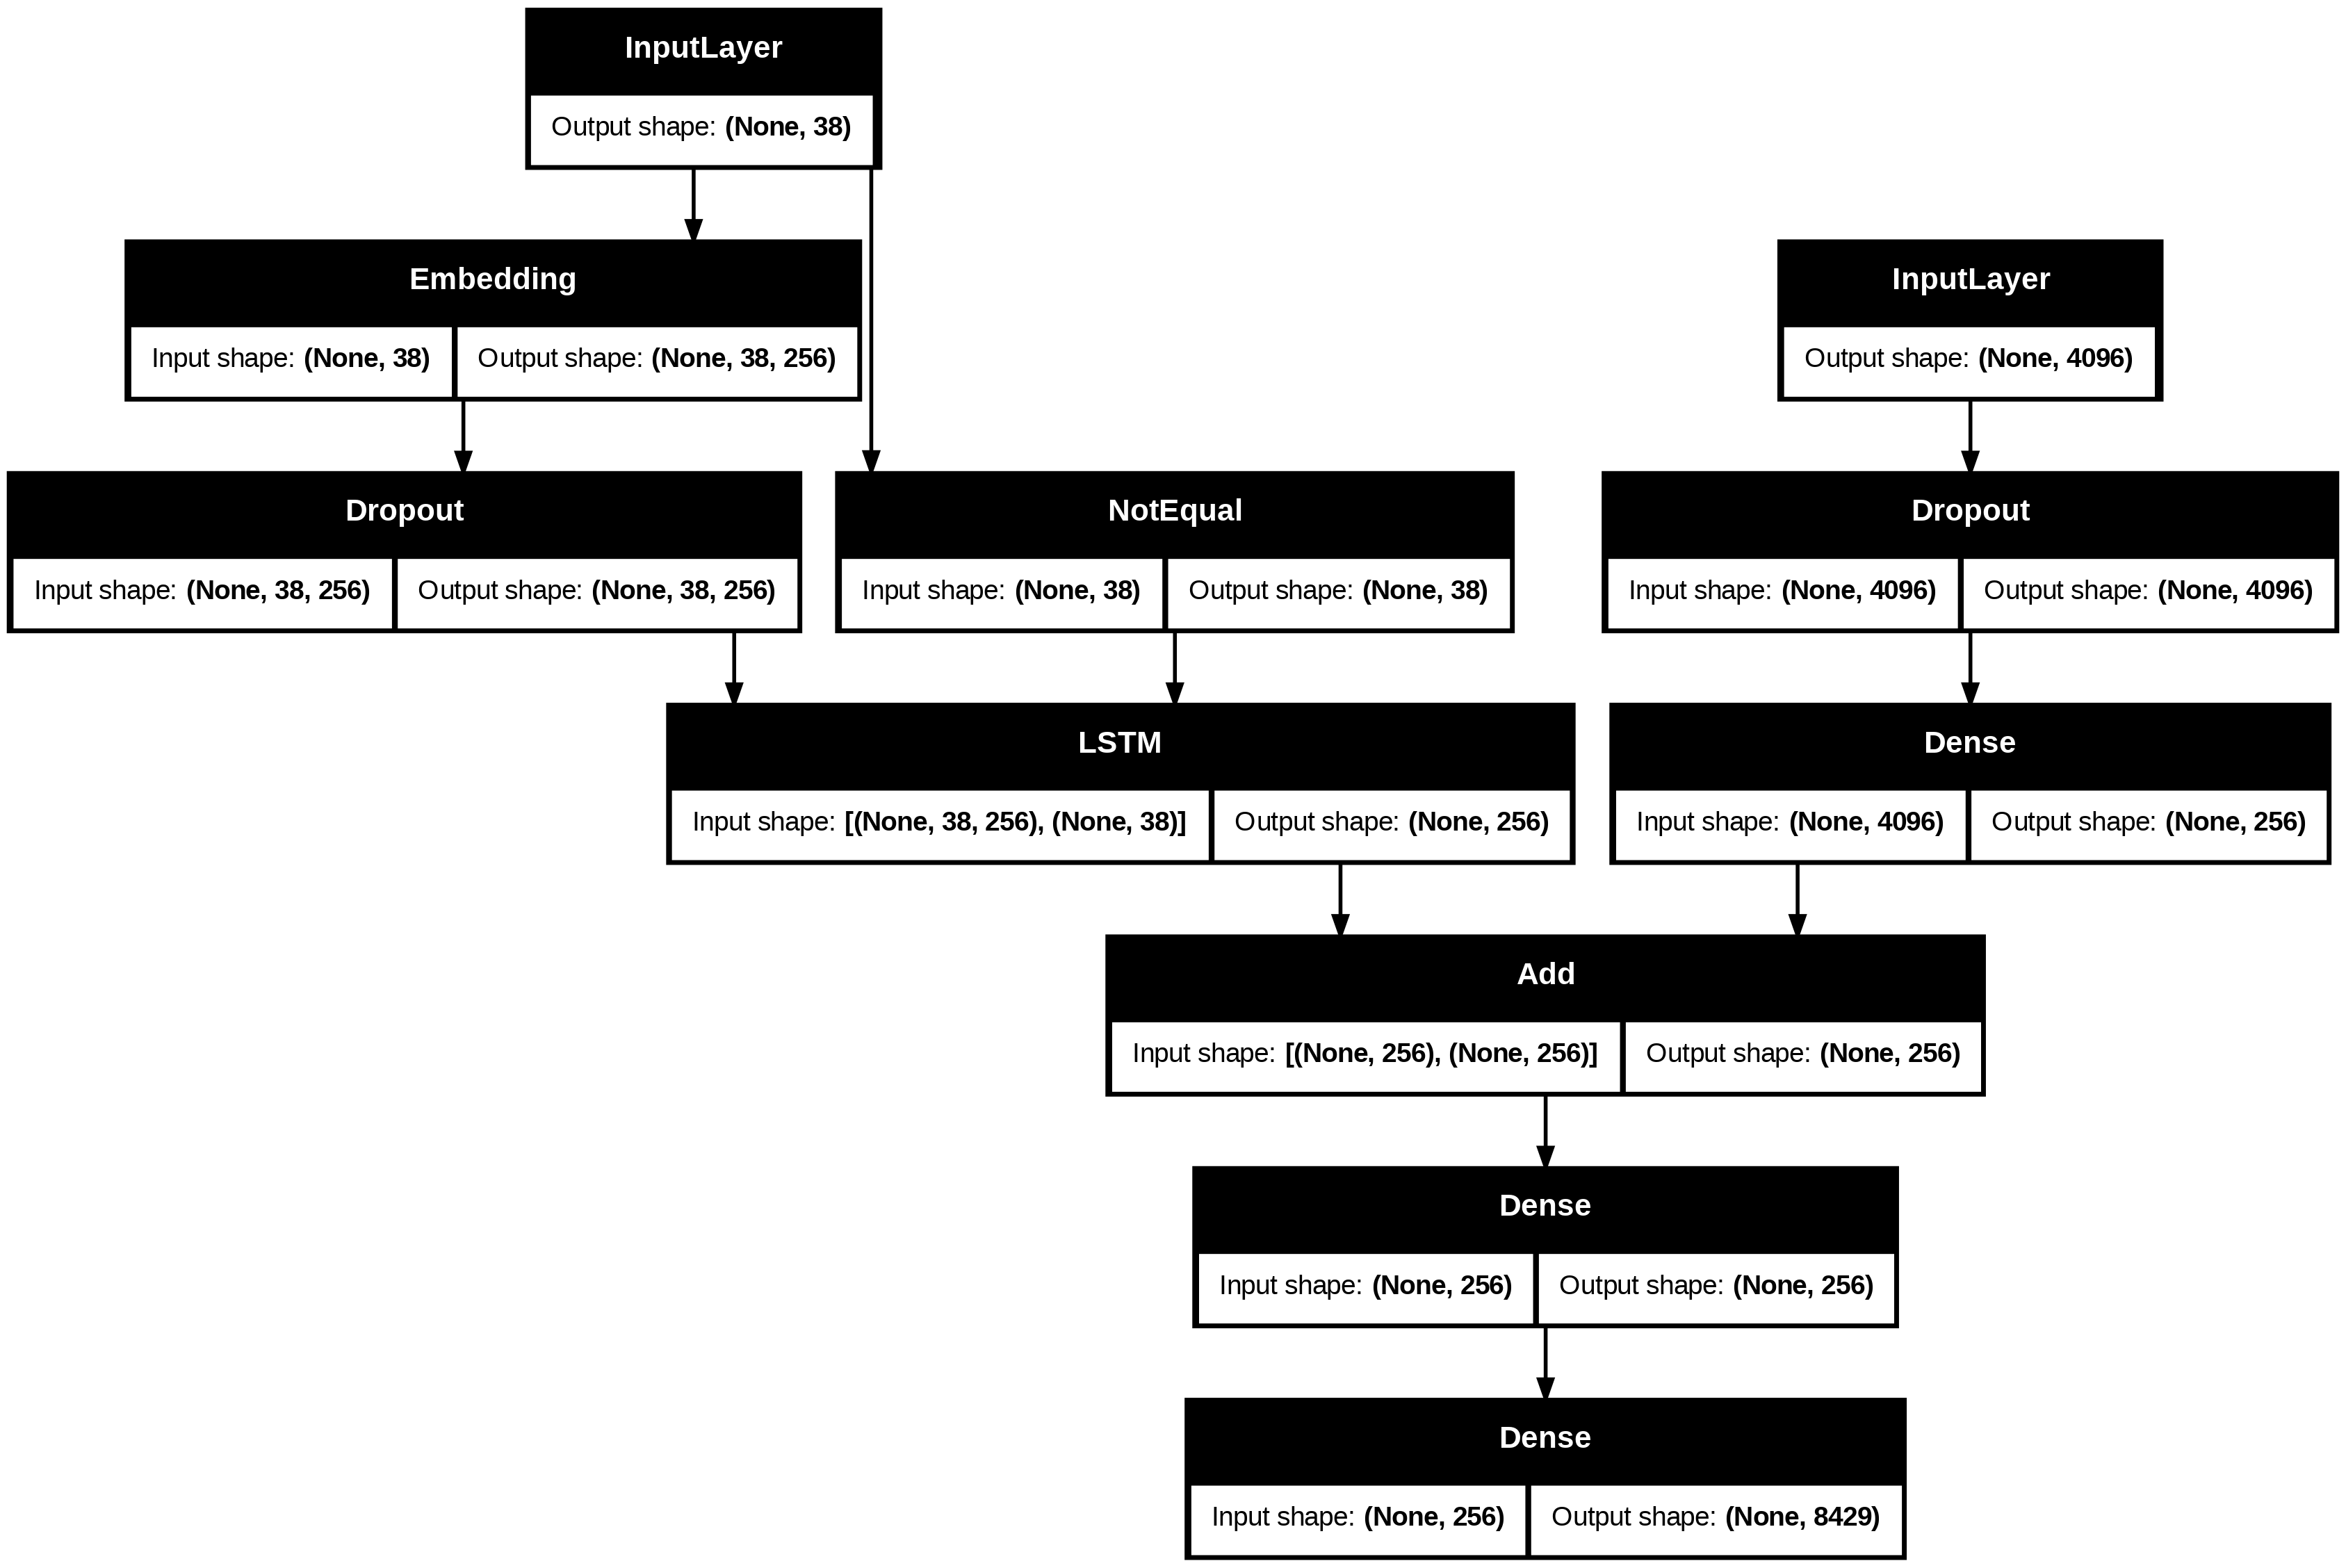

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 282ms/step - loss: 5.3817
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - loss: 3.5705
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 274ms/step - loss: 3.1411
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - loss: 2.8935
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - loss: 2.7164
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 290ms/step - loss: 2.5849
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 2.4875
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - loss: 2.4075
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - loss: 2.3412
227/227 ━━━━━━━━━━━━━━━━━━━━ 87s 384ms/step - loss: 2.2797
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 395ms/step - loss: 2.2235
227/227 ━━━━━━━━━━━━━━━━━━━━ 91s 402ms/step - loss: 2.1780
227/227 ━━━━━━━━━━━━━━━━━━━━ 108s 478ms/step - loss: 2.1369
227/227 ━━━━━━━━━━━━━━━━━━━━ 116s 511ms/step - loss: 2.0951
227/227 ━━━━━━━━━━━━━━━━━━━━ 120s 531ms/step - loss: 2.0616


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.keras')

Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  0%|          | 1/810 [00:02<32:10,  2.39s/it]

BLEU-1: 0.636364
BLEU-2: 0.356753


  0%|          | 2/810 [00:03<18:52,  1.40s/it]

BLEU-1: 0.666667
BLEU-2: 0.458831


  0%|          | 3/810 [00:04<18:18,  1.36s/it]

BLEU-1: 0.564103
BLEU-2: 0.354057


  0%|          | 4/810 [00:05<18:01,  1.34s/it]

BLEU-1: 0.529412
BLEU-2: 0.318397


  1%|          | 5/810 [00:06<17:34,  1.31s/it]

BLEU-1: 0.555556
BLEU-2: 0.352875


  1%|          | 6/810 [00:08<17:12,  1.28s/it]

BLEU-1: 0.551282
BLEU-2: 0.327405


  1%|          | 7/810 [00:08<14:08,  1.06s/it]

BLEU-1: 0.563218
BLEU-2: 0.335624


  1%|          | 8/810 [00:10<15:17,  1.14s/it]

BLEU-1: 0.533333
BLEU-2: 0.314594


  1%|          | 9/810 [00:10<13:49,  1.04s/it]

BLEU-1: 0.521368
BLEU-2: 0.302857


  1%|          | 10/810 [00:11<12:34,  1.06it/s]

BLEU-1: 0.531250
BLEU-2: 0.307481


  1%|▏         | 11/810 [00:12<11:05,  1.20it/s]

BLEU-1: 0.532847
BLEU-2: 0.305019


  1%|▏         | 12/810 [00:13<11:48,  1.13it/s]

BLEU-1: 0.556291
BLEU-2: 0.328720


  2%|▏         | 13/810 [00:14<11:28,  1.16it/s]

BLEU-1: 0.570552
BLEU-2: 0.348881


  2%|▏         | 14/810 [00:15<12:07,  1.09it/s]

BLEU-1: 0.567416
BLEU-2: 0.342980


  2%|▏         | 15/810 [00:16<12:04,  1.10it/s]

BLEU-1: 0.554974
BLEU-2: 0.336923


  2%|▏         | 16/810 [00:17<13:40,  1.03s/it]

BLEU-1: 0.538095
BLEU-2: 0.324654


  2%|▏         | 17/810 [00:18<13:41,  1.04s/it]

BLEU-1: 0.552036
BLEU-2: 0.337127


  2%|▏         | 18/810 [00:20<16:03,  1.22s/it]

BLEU-1: 0.555085
BLEU-2: 0.342240


  2%|▏         | 19/810 [00:21<16:40,  1.26s/it]

BLEU-1: 0.553785
BLEU-2: 0.348909


  2%|▏         | 20/810 [00:22<16:48,  1.28s/it]

BLEU-1: 0.551852
BLEU-2: 0.351589


  3%|▎         | 21/810 [00:23<14:34,  1.11s/it]

BLEU-1: 0.551601
BLEU-2: 0.350784


  3%|▎         | 22/810 [00:23<12:26,  1.06it/s]

BLEU-1: 0.555172
BLEU-2: 0.355477


  3%|▎         | 23/810 [00:24<11:51,  1.11it/s]

BLEU-1: 0.559603
BLEU-2: 0.358284


  3%|▎         | 24/810 [00:25<11:06,  1.18it/s]

BLEU-1: 0.567308
BLEU-2: 0.368670


  3%|▎         | 25/810 [00:26<12:50,  1.02it/s]

BLEU-1: 0.568807
BLEU-2: 0.373332


  3%|▎         | 26/810 [00:27<11:14,  1.16it/s]

BLEU-1: 0.577381
BLEU-2: 0.383587


  3%|▎         | 27/810 [00:28<11:35,  1.13it/s]

BLEU-1: 0.574286
BLEU-2: 0.379494


  3%|▎         | 28/810 [00:29<12:47,  1.02it/s]

BLEU-1: 0.566757
BLEU-2: 0.372510


  4%|▎         | 29/810 [00:30<12:28,  1.04it/s]

BLEU-1: 0.571053
BLEU-2: 0.376222


  4%|▎         | 30/810 [00:32<15:22,  1.18s/it]

BLEU-1: 0.578283
BLEU-2: 0.385384


  4%|▍         | 31/810 [00:32<13:59,  1.08s/it]

BLEU-1: 0.586634
BLEU-2: 0.394591


  4%|▍         | 32/810 [00:34<14:57,  1.15s/it]

BLEU-1: 0.587530
BLEU-2: 0.394534


  4%|▍         | 33/810 [00:35<13:36,  1.05s/it]

BLEU-1: 0.582751
BLEU-2: 0.389325


  4%|▍         | 34/810 [00:35<12:03,  1.07it/s]

BLEU-1: 0.585421
BLEU-2: 0.391435


  4%|▍         | 35/810 [00:36<10:31,  1.23it/s]

BLEU-1: 0.592841
BLEU-2: 0.401448


  4%|▍         | 36/810 [00:37<10:53,  1.18it/s]

BLEU-1: 0.595652
BLEU-2: 0.401941


  5%|▍         | 37/810 [00:38<10:55,  1.18it/s]

BLEU-1: 0.595339
BLEU-2: 0.403563


  5%|▍         | 38/810 [00:39<12:23,  1.04it/s]

BLEU-1: 0.589796
BLEU-2: 0.397351


  5%|▍         | 39/810 [00:40<13:10,  1.03s/it]

BLEU-1: 0.588933
BLEU-2: 0.393846


  5%|▍         | 40/810 [00:41<11:54,  1.08it/s]

BLEU-1: 0.589147
BLEU-2: 0.390176


  5%|▌         | 41/810 [00:42<13:08,  1.03s/it]

BLEU-1: 0.580524
BLEU-2: 0.385187


  5%|▌         | 42/810 [00:43<12:21,  1.04it/s]

BLEU-1: 0.582418
BLEU-2: 0.384598


  5%|▌         | 43/810 [00:44<12:16,  1.04it/s]

BLEU-1: 0.586022
BLEU-2: 0.387561


  5%|▌         | 44/810 [00:45<12:02,  1.06it/s]

BLEU-1: 0.590829
BLEU-2: 0.391967


  6%|▌         | 45/810 [00:46<14:35,  1.14s/it]

BLEU-1: 0.593804
BLEU-2: 0.396628


  6%|▌         | 46/810 [00:47<14:18,  1.12s/it]

BLEU-1: 0.597643
BLEU-2: 0.403110


  6%|▌         | 47/810 [00:48<13:15,  1.04s/it]

BLEU-1: 0.600660
BLEU-2: 0.406789


  6%|▌         | 48/810 [00:49<12:19,  1.03it/s]

BLEU-1: 0.603560
BLEU-2: 0.410319


  6%|▌         | 49/810 [00:50<11:45,  1.08it/s]

BLEU-1: 0.604762
BLEU-2: 0.410640


  6%|▌         | 50/810 [00:51<11:14,  1.13it/s]

BLEU-1: 0.608424
BLEU-2: 0.417112


  6%|▋         | 51/810 [00:51<10:47,  1.17it/s]

BLEU-1: 0.608896
BLEU-2: 0.417444


  6%|▋         | 52/810 [00:52<09:48,  1.29it/s]

BLEU-1: 0.609682
BLEU-2: 0.418564


  7%|▋         | 53/810 [00:53<09:55,  1.27it/s]

BLEU-1: 0.612184
BLEU-2: 0.419233


  7%|▋         | 54/810 [00:54<12:10,  1.03it/s]

BLEU-1: 0.606936
BLEU-2: 0.414955


  7%|▋         | 55/810 [00:55<11:02,  1.14it/s]

BLEU-1: 0.609687
BLEU-2: 0.418656


  7%|▋         | 56/810 [00:56<10:51,  1.16it/s]

BLEU-1: 0.613445
BLEU-2: 0.423083


  7%|▋         | 57/810 [00:56<10:03,  1.25it/s]

BLEU-1: 0.612725
BLEU-2: 0.422471


  7%|▋         | 58/810 [00:58<11:52,  1.06it/s]

BLEU-1: 0.614130
BLEU-2: 0.423495


  7%|▋         | 59/810 [00:59<13:46,  1.10s/it]

BLEU-1: 0.619493
BLEU-2: 0.426915


  7%|▋         | 60/810 [01:01<16:28,  1.32s/it]

BLEU-1: 0.609883
BLEU-2: 0.418905


  8%|▊         | 61/810 [01:02<14:16,  1.14s/it]

BLEU-1: 0.614891
BLEU-2: 0.424079


  8%|▊         | 62/810 [01:02<12:44,  1.02s/it]

BLEU-1: 0.618987
BLEU-2: 0.427557


  8%|▊         | 63/810 [01:03<13:08,  1.06s/it]

BLEU-1: 0.620347
BLEU-2: 0.430526


  8%|▊         | 64/810 [01:04<11:57,  1.04it/s]

BLEU-1: 0.618115
BLEU-2: 0.427848


  8%|▊         | 65/810 [01:05<12:40,  1.02s/it]

BLEU-1: 0.619904
BLEU-2: 0.426828


  8%|▊         | 66/810 [01:06<11:54,  1.04it/s]

BLEU-1: 0.619385
BLEU-2: 0.424567


  8%|▊         | 67/810 [01:07<11:52,  1.04it/s]

BLEU-1: 0.615116
BLEU-2: 0.420542


  8%|▊         | 68/810 [01:08<11:55,  1.04it/s]

BLEU-1: 0.612128
BLEU-2: 0.417034


  9%|▊         | 69/810 [01:09<11:31,  1.07it/s]

BLEU-1: 0.616253
BLEU-2: 0.422807


  9%|▊         | 70/810 [01:10<10:29,  1.17it/s]

BLEU-1: 0.614525
BLEU-2: 0.421048


  9%|▉         | 71/810 [01:10<10:28,  1.18it/s]

BLEU-1: 0.614618
BLEU-2: 0.420184


  9%|▉         | 72/810 [01:12<11:47,  1.04it/s]

BLEU-1: 0.617744
BLEU-2: 0.424218


  9%|▉         | 73/810 [01:13<14:05,  1.15s/it]

BLEU-1: 0.620690
BLEU-2: 0.426866


  9%|▉         | 74/810 [01:14<12:54,  1.05s/it]

BLEU-1: 0.619149
BLEU-2: 0.425303


  9%|▉         | 75/810 [01:15<11:00,  1.11it/s]

BLEU-1: 0.619198
BLEU-2: 0.425283


  9%|▉         | 76/810 [01:16<11:01,  1.11it/s]

BLEU-1: 0.622268
BLEU-2: 0.427567


 10%|▉         | 77/810 [01:16<10:08,  1.20it/s]

BLEU-1: 0.623069
BLEU-2: 0.428132


 10%|▉         | 78/810 [01:17<11:18,  1.08it/s]

BLEU-1: 0.623100
BLEU-2: 0.427010


 10%|▉         | 79/810 [01:18<10:39,  1.14it/s]

BLEU-1: 0.625251
BLEU-2: 0.429392


 10%|▉         | 80/810 [01:19<11:46,  1.03it/s]

BLEU-1: 0.624631
BLEU-2: 0.428620


 10%|█         | 81/810 [01:20<11:12,  1.08it/s]

BLEU-1: 0.627069
BLEU-2: 0.428501


 10%|█         | 82/810 [01:21<10:04,  1.20it/s]

BLEU-1: 0.627413
BLEU-2: 0.429888


 10%|█         | 83/810 [01:22<10:28,  1.16it/s]

BLEU-1: 0.630124
BLEU-2: 0.434934


 10%|█         | 84/810 [01:22<09:34,  1.26it/s]

BLEU-1: 0.630435
BLEU-2: 0.435486


 10%|█         | 85/810 [01:24<11:44,  1.03it/s]

BLEU-1: 0.628492
BLEU-2: 0.433708


 11%|█         | 86/810 [01:25<13:09,  1.09s/it]

BLEU-1: 0.627072
BLEU-2: 0.432282


 11%|█         | 87/810 [01:26<12:44,  1.06s/it]

BLEU-1: 0.628885
BLEU-2: 0.433565


 11%|█         | 88/810 [01:27<12:45,  1.06s/it]

BLEU-1: 0.626691
BLEU-2: 0.431256


 11%|█         | 89/810 [01:28<11:22,  1.06it/s]

BLEU-1: 0.626452
BLEU-2: 0.430700


 11%|█         | 90/810 [01:28<10:24,  1.15it/s]

BLEU-1: 0.627104
BLEU-2: 0.431858


 11%|█         | 91/810 [01:29<09:53,  1.21it/s]

BLEU-1: 0.625988
BLEU-2: 0.431005


 11%|█▏        | 92/810 [01:30<09:02,  1.32it/s]

BLEU-1: 0.626853
BLEU-2: 0.431938


 11%|█▏        | 93/810 [01:31<10:16,  1.16it/s]

BLEU-1: 0.628227
BLEU-2: 0.432298


 12%|█▏        | 94/810 [01:32<09:45,  1.22it/s]

BLEU-1: 0.629693
BLEU-2: 0.435038


 12%|█▏        | 95/810 [01:33<10:34,  1.13it/s]

BLEU-1: 0.628162
BLEU-2: 0.433908


 12%|█▏        | 96/810 [01:33<09:37,  1.24it/s]

BLEU-1: 0.630126
BLEU-2: 0.436955


 12%|█▏        | 97/810 [01:34<09:22,  1.27it/s]

BLEU-1: 0.629876
BLEU-2: 0.437046


 12%|█▏        | 98/810 [01:35<10:21,  1.15it/s]

BLEU-1: 0.629508
BLEU-2: 0.436118


 12%|█▏        | 99/810 [01:36<10:04,  1.18it/s]

BLEU-1: 0.628757
BLEU-2: 0.435844


 12%|█▏        | 100/810 [01:37<11:08,  1.06it/s]

BLEU-1: 0.631240
BLEU-2: 0.438585


 12%|█▏        | 101/810 [01:38<11:55,  1.01s/it]

BLEU-1: 0.631495
BLEU-2: 0.438399


 13%|█▎        | 102/810 [01:39<12:10,  1.03s/it]

BLEU-1: 0.632540
BLEU-2: 0.439735


 13%|█▎        | 103/810 [01:40<10:45,  1.09it/s]

BLEU-1: 0.634069
BLEU-2: 0.440798


 13%|█▎        | 104/810 [01:41<10:07,  1.16it/s]

BLEU-1: 0.636150
BLEU-2: 0.442894


 13%|█▎        | 105/810 [01:42<11:36,  1.01it/s]

BLEU-1: 0.636574
BLEU-2: 0.442292


 13%|█▎        | 106/810 [01:43<11:17,  1.04it/s]

BLEU-1: 0.634557
BLEU-2: 0.440765


 13%|█▎        | 107/810 [01:44<10:53,  1.08it/s]

BLEU-1: 0.635606
BLEU-2: 0.440911


 13%|█▎        | 108/810 [01:44<09:57,  1.17it/s]

BLEU-1: 0.635064
BLEU-2: 0.440459


 13%|█▎        | 109/810 [01:45<09:25,  1.24it/s]

BLEU-1: 0.634802
BLEU-2: 0.438754


 14%|█▎        | 110/810 [01:46<10:08,  1.15it/s]

BLEU-1: 0.637103
BLEU-2: 0.441908


 14%|█▎        | 111/810 [01:47<09:52,  1.18it/s]

BLEU-1: 0.638298
BLEU-2: 0.443037


 14%|█▍        | 112/810 [01:48<09:19,  1.25it/s]

BLEU-1: 0.638484
BLEU-2: 0.443410


 14%|█▍        | 113/810 [01:48<09:14,  1.26it/s]

BLEU-1: 0.638467
BLEU-2: 0.442792


 14%|█▍        | 114/810 [01:50<10:47,  1.08it/s]

BLEU-1: 0.635908
BLEU-2: 0.440614


 14%|█▍        | 115/810 [01:52<16:53,  1.46s/it]

BLEU-1: 0.631949
BLEU-2: 0.437188


 14%|█▍        | 116/810 [01:54<15:59,  1.38s/it]

BLEU-1: 0.631176
BLEU-2: 0.437174


 14%|█▍        | 117/810 [01:54<14:03,  1.22s/it]

BLEU-1: 0.631470
BLEU-2: 0.437638


 15%|█▍        | 118/810 [01:56<14:56,  1.30s/it]

BLEU-1: 0.627211
BLEU-2: 0.433992


 15%|█▍        | 119/810 [01:57<14:58,  1.30s/it]

BLEU-1: 0.625252
BLEU-2: 0.432045


 15%|█▍        | 120/810 [01:58<13:06,  1.14s/it]

BLEU-1: 0.625333
BLEU-2: 0.431556


 15%|█▍        | 121/810 [01:59<12:41,  1.10s/it]

BLEU-1: 0.626156
BLEU-2: 0.431386


 15%|█▌        | 122/810 [02:00<12:56,  1.13s/it]

BLEU-1: 0.625735
BLEU-2: 0.430852


 15%|█▌        | 123/810 [02:01<11:09,  1.03it/s]

BLEU-1: 0.626623
BLEU-2: 0.431479


 15%|█▌        | 124/810 [02:02<10:43,  1.07it/s]

BLEU-1: 0.626933
BLEU-2: 0.431449


 15%|█▌        | 125/810 [02:03<10:55,  1.04it/s]

BLEU-1: 0.626437
BLEU-2: 0.430845


 16%|█▌        | 126/810 [02:05<15:03,  1.32s/it]

BLEU-1: 0.623975
BLEU-2: 0.427836


 16%|█▌        | 127/810 [02:06<14:00,  1.23s/it]

BLEU-1: 0.625471
BLEU-2: 0.429667


 16%|█▌        | 128/810 [02:07<12:55,  1.14s/it]

BLEU-1: 0.626011
BLEU-2: 0.430570


 16%|█▌        | 129/810 [02:07<11:11,  1.01it/s]

BLEU-1: 0.626856
BLEU-2: 0.431169


 16%|█▌        | 130/810 [02:08<10:18,  1.10it/s]

BLEU-1: 0.626921
BLEU-2: 0.431693


 16%|█▌        | 131/810 [02:09<10:08,  1.12it/s]

BLEU-1: 0.628432
BLEU-2: 0.433528


 16%|█▋        | 132/810 [02:10<10:48,  1.05it/s]

BLEU-1: 0.627570
BLEU-2: 0.432665


 16%|█▋        | 133/810 [02:11<09:40,  1.17it/s]

BLEU-1: 0.626955
BLEU-2: 0.431937


 17%|█▋        | 134/810 [02:11<08:45,  1.29it/s]

BLEU-1: 0.628144
BLEU-2: 0.433252


 17%|█▋        | 135/810 [02:12<08:47,  1.28it/s]

BLEU-1: 0.626413
BLEU-2: 0.431253


 17%|█▋        | 136/810 [02:13<09:14,  1.21it/s]

BLEU-1: 0.626328
BLEU-2: 0.431427


 17%|█▋        | 137/810 [02:14<09:03,  1.24it/s]

BLEU-1: 0.626393
BLEU-2: 0.431926


 17%|█▋        | 138/810 [02:15<09:17,  1.21it/s]

BLEU-1: 0.624927
BLEU-2: 0.430375


 17%|█▋        | 139/810 [02:16<10:22,  1.08it/s]

BLEU-1: 0.626082
BLEU-2: 0.432389


 17%|█▋        | 140/810 [02:17<11:13,  1.00s/it]

BLEU-1: 0.627080
BLEU-2: 0.433778


 17%|█▋        | 141/810 [02:18<11:38,  1.04s/it]

BLEU-1: 0.628637
BLEU-2: 0.434899


 18%|█▊        | 142/810 [02:20<13:49,  1.24s/it]

BLEU-1: 0.627329
BLEU-2: 0.433508


 18%|█▊        | 143/810 [02:20<11:57,  1.08s/it]

BLEU-1: 0.627737
BLEU-2: 0.433783


 18%|█▊        | 144/810 [02:22<12:01,  1.08s/it]

BLEU-1: 0.625835
BLEU-2: 0.431725


 18%|█▊        | 145/810 [02:23<12:14,  1.10s/it]

BLEU-1: 0.627483
BLEU-2: 0.433395


 18%|█▊        | 146/810 [02:24<12:13,  1.10s/it]

BLEU-1: 0.625821
BLEU-2: 0.431748


 18%|█▊        | 147/810 [02:25<12:02,  1.09s/it]

BLEU-1: 0.625610
BLEU-2: 0.431176


 18%|█▊        | 148/810 [02:26<11:00,  1.00it/s]

BLEU-1: 0.625135
BLEU-2: 0.430173


 18%|█▊        | 149/810 [02:26<09:32,  1.15it/s]

BLEU-1: 0.626208
BLEU-2: 0.431360


 19%|█▊        | 150/810 [02:27<10:10,  1.08it/s]

BLEU-1: 0.625999
BLEU-2: 0.430800


 19%|█▊        | 151/810 [02:28<09:51,  1.11it/s]

BLEU-1: 0.626787
BLEU-2: 0.431380


 19%|█▉        | 152/810 [02:29<10:57,  1.00it/s]

BLEU-1: 0.626842
BLEU-2: 0.430996


 19%|█▉        | 153/810 [02:31<12:15,  1.12s/it]

BLEU-1: 0.627943
BLEU-2: 0.431803


 19%|█▉        | 154/810 [02:32<12:51,  1.18s/it]

BLEU-1: 0.627992
BLEU-2: 0.431009


 19%|█▉        | 155/810 [02:33<11:58,  1.10s/it]

BLEU-1: 0.628749
BLEU-2: 0.431984


 19%|█▉        | 156/810 [02:34<12:15,  1.12s/it]

BLEU-1: 0.628718
BLEU-2: 0.431790


 19%|█▉        | 157/810 [02:35<11:58,  1.10s/it]

BLEU-1: 0.630855
BLEU-2: 0.433388


 20%|█▉        | 158/810 [02:36<11:34,  1.06s/it]

BLEU-1: 0.631765
BLEU-2: 0.433872


 20%|█▉        | 159/810 [02:37<11:12,  1.03s/it]

BLEU-1: 0.633166
BLEU-2: 0.434919


 20%|█▉        | 160/810 [02:38<11:37,  1.07s/it]

BLEU-1: 0.632602
BLEU-2: 0.434536


 20%|█▉        | 161/810 [02:40<12:02,  1.11s/it]

BLEU-1: 0.633037
BLEU-2: 0.435671


 20%|██        | 162/810 [02:41<12:18,  1.14s/it]

BLEU-1: 0.631321
BLEU-2: 0.433841


 20%|██        | 163/810 [02:42<11:35,  1.08s/it]

BLEU-1: 0.631040
BLEU-2: 0.434022


 20%|██        | 164/810 [02:43<12:02,  1.12s/it]

BLEU-1: 0.631732
BLEU-2: 0.434535


 20%|██        | 165/810 [02:45<14:40,  1.37s/it]

BLEU-1: 0.631680
BLEU-2: 0.434713


 20%|██        | 166/810 [02:46<14:09,  1.32s/it]

BLEU-1: 0.631100
BLEU-2: 0.433913


 21%|██        | 167/810 [02:47<13:05,  1.22s/it]

BLEU-1: 0.629577
BLEU-2: 0.432420


 21%|██        | 168/810 [02:48<11:28,  1.07s/it]

BLEU-1: 0.629910
BLEU-2: 0.432282


 21%|██        | 169/810 [02:49<10:53,  1.02s/it]

BLEU-1: 0.629647
BLEU-2: 0.432094


 21%|██        | 170/810 [02:50<11:45,  1.10s/it]

BLEU-1: 0.630252
BLEU-2: 0.432396


 21%|██        | 171/810 [02:51<11:39,  1.09s/it]

BLEU-1: 0.630455
BLEU-2: 0.432369


 21%|██        | 172/810 [02:52<10:29,  1.01it/s]

BLEU-1: 0.630143
BLEU-2: 0.431759


 21%|██▏       | 173/810 [02:53<09:54,  1.07it/s]

BLEU-1: 0.630175
BLEU-2: 0.431785


 21%|██▏       | 174/810 [02:53<09:16,  1.14it/s]

BLEU-1: 0.630952
BLEU-2: 0.432900


 22%|██▏       | 175/810 [02:54<09:33,  1.11it/s]

BLEU-1: 0.631771
BLEU-2: 0.434058


 22%|██▏       | 176/810 [02:55<09:28,  1.11it/s]

BLEU-1: 0.631960
BLEU-2: 0.434023


 22%|██▏       | 177/810 [02:57<12:41,  1.20s/it]

BLEU-1: 0.631461
BLEU-2: 0.433328


 22%|██▏       | 178/810 [02:59<13:23,  1.27s/it]

BLEU-1: 0.632097
BLEU-2: 0.433450


 22%|██▏       | 179/810 [02:59<11:34,  1.10s/it]

BLEU-1: 0.631790
BLEU-2: 0.432859


 22%|██▏       | 180/810 [03:00<11:06,  1.06s/it]

BLEU-1: 0.630810
BLEU-2: 0.432327


 22%|██▏       | 181/810 [03:01<10:09,  1.03it/s]

BLEU-1: 0.632437
BLEU-2: 0.434398


 22%|██▏       | 182/810 [03:02<09:14,  1.13it/s]

BLEU-1: 0.633450
BLEU-2: 0.435306


 23%|██▎       | 183/810 [03:03<09:27,  1.11it/s]

BLEU-1: 0.632911
BLEU-2: 0.434572


 23%|██▎       | 184/810 [03:04<09:35,  1.09it/s]

BLEU-1: 0.634115
BLEU-2: 0.436159


 23%|██▎       | 185/810 [03:04<08:33,  1.22it/s]

BLEU-1: 0.634948
BLEU-2: 0.437436


 23%|██▎       | 186/810 [03:05<09:24,  1.11it/s]

BLEU-1: 0.635153
BLEU-2: 0.437432


 23%|██▎       | 187/810 [03:06<08:39,  1.20it/s]

BLEU-1: 0.635702
BLEU-2: 0.437821


 23%|██▎       | 188/810 [03:07<09:18,  1.11it/s]

BLEU-1: 0.636170
BLEU-2: 0.438680


 23%|██▎       | 189/810 [03:08<09:21,  1.11it/s]

BLEU-1: 0.635902
BLEU-2: 0.438478


 23%|██▎       | 190/810 [03:10<11:56,  1.15s/it]

BLEU-1: 0.634300
BLEU-2: 0.436986


 24%|██▎       | 191/810 [03:11<11:28,  1.11s/it]

BLEU-1: 0.635107
BLEU-2: 0.437889


 24%|██▎       | 192/810 [03:12<11:42,  1.14s/it]

BLEU-1: 0.634960
BLEU-2: 0.436944


 24%|██▍       | 193/810 [03:13<12:00,  1.17s/it]

BLEU-1: 0.634065
BLEU-2: 0.436142


 24%|██▍       | 194/810 [03:14<12:14,  1.19s/it]

BLEU-1: 0.634568
BLEU-2: 0.435729


 24%|██▍       | 195/810 [03:15<10:52,  1.06s/it]

BLEU-1: 0.635246
BLEU-2: 0.436710


 24%|██▍       | 196/810 [03:16<11:30,  1.13s/it]

BLEU-1: 0.632479
BLEU-2: 0.434213


 24%|██▍       | 197/810 [03:19<15:03,  1.47s/it]

BLEU-1: 0.627412
BLEU-2: 0.429629


 24%|██▍       | 198/810 [03:20<13:25,  1.32s/it]

BLEU-1: 0.628948
BLEU-2: 0.430621


 25%|██▍       | 199/810 [03:21<13:11,  1.29s/it]

BLEU-1: 0.627879
BLEU-2: 0.429399


 25%|██▍       | 200/810 [03:21<11:03,  1.09s/it]

BLEU-1: 0.627870
BLEU-2: 0.429064


 25%|██▍       | 201/810 [03:22<10:56,  1.08s/it]

BLEU-1: 0.627613
BLEU-2: 0.428554


 25%|██▍       | 202/810 [03:24<12:59,  1.28s/it]

BLEU-1: 0.628482
BLEU-2: 0.429536


 25%|██▌       | 203/810 [03:25<12:13,  1.21s/it]

BLEU-1: 0.628125
BLEU-2: 0.428813


 25%|██▌       | 204/810 [03:26<10:35,  1.05s/it]

BLEU-1: 0.629039
BLEU-2: 0.430257


 25%|██▌       | 205/810 [03:27<10:53,  1.08s/it]

BLEU-1: 0.628240
BLEU-2: 0.429242


 25%|██▌       | 206/810 [03:28<10:35,  1.05s/it]

BLEU-1: 0.627406
BLEU-2: 0.428492


 26%|██▌       | 207/810 [03:29<11:38,  1.16s/it]

BLEU-1: 0.626290
BLEU-2: 0.428029


 26%|██▌       | 208/810 [03:30<11:06,  1.11s/it]

BLEU-1: 0.626236
BLEU-2: 0.428159


 26%|██▌       | 209/810 [03:31<10:27,  1.04s/it]

BLEU-1: 0.625662
BLEU-2: 0.427897


 26%|██▌       | 210/810 [03:32<10:00,  1.00s/it]

BLEU-1: 0.624341
BLEU-2: 0.426481


 26%|██▌       | 211/810 [03:33<09:39,  1.03it/s]

BLEU-1: 0.624906
BLEU-2: 0.427210


 26%|██▌       | 212/810 [03:34<10:07,  1.02s/it]

BLEU-1: 0.624021
BLEU-2: 0.425695


 26%|██▋       | 213/810 [03:35<09:35,  1.04it/s]

BLEU-1: 0.625139
BLEU-2: 0.426955


 26%|██▋       | 214/810 [03:36<09:55,  1.00it/s]

BLEU-1: 0.626019
BLEU-2: 0.428335


 27%|██▋       | 215/810 [03:38<12:09,  1.23s/it]

BLEU-1: 0.625737
BLEU-2: 0.428002


 27%|██▋       | 216/810 [03:39<10:48,  1.09s/it]

BLEU-1: 0.626745
BLEU-2: 0.429327


 27%|██▋       | 217/810 [03:40<11:08,  1.13s/it]

BLEU-1: 0.626370
BLEU-2: 0.429080


 27%|██▋       | 218/810 [03:41<11:16,  1.14s/it]

BLEU-1: 0.626589
BLEU-2: 0.429122


 27%|██▋       | 219/810 [03:42<10:21,  1.05s/it]

BLEU-1: 0.626266
BLEU-2: 0.429029


 27%|██▋       | 220/810 [03:43<10:40,  1.09s/it]

BLEU-1: 0.625180
BLEU-2: 0.428255


 27%|██▋       | 221/810 [03:44<11:14,  1.15s/it]

BLEU-1: 0.623525
BLEU-2: 0.426925


 27%|██▋       | 222/810 [03:45<10:56,  1.12s/it]

BLEU-1: 0.624333
BLEU-2: 0.427258


 28%|██▊       | 223/810 [03:46<10:24,  1.06s/it]

BLEU-1: 0.623804
BLEU-2: 0.427297


 28%|██▊       | 224/810 [03:47<10:25,  1.07s/it]

BLEU-1: 0.623898
BLEU-2: 0.427663


 28%|██▊       | 225/810 [03:49<11:34,  1.19s/it]

BLEU-1: 0.623992
BLEU-2: 0.427192


 28%|██▊       | 226/810 [03:50<12:21,  1.27s/it]

BLEU-1: 0.624039
BLEU-2: 0.426952


 28%|██▊       | 227/810 [03:51<11:09,  1.15s/it]

BLEU-1: 0.624128
BLEU-2: 0.426855


 28%|██▊       | 228/810 [03:52<10:31,  1.09s/it]

BLEU-1: 0.623264
BLEU-2: 0.425673


 28%|██▊       | 229/810 [03:53<10:37,  1.10s/it]

BLEU-1: 0.622798
BLEU-2: 0.424946


 28%|██▊       | 230/810 [03:54<10:12,  1.06s/it]

BLEU-1: 0.623453
BLEU-2: 0.425038


 29%|██▊       | 231/810 [03:55<09:43,  1.01s/it]

BLEU-1: 0.622603
BLEU-2: 0.424151


 29%|██▊       | 232/810 [03:56<09:03,  1.06it/s]

BLEU-1: 0.622867
BLEU-2: 0.424893


 29%|██▉       | 233/810 [03:57<08:13,  1.17it/s]

BLEU-1: 0.622873
BLEU-2: 0.424345


 29%|██▉       | 234/810 [03:58<08:45,  1.10it/s]

BLEU-1: 0.622629
BLEU-2: 0.423787


 29%|██▉       | 235/810 [03:58<08:10,  1.17it/s]

BLEU-1: 0.622425
BLEU-2: 0.423365


 29%|██▉       | 236/810 [03:59<08:23,  1.14it/s]

BLEU-1: 0.622603
BLEU-2: 0.423650


 29%|██▉       | 237/810 [04:00<08:05,  1.18it/s]

BLEU-1: 0.622528
BLEU-2: 0.423465


 29%|██▉       | 238/810 [04:01<08:00,  1.19it/s]

BLEU-1: 0.622578
BLEU-2: 0.422980


 30%|██▉       | 239/810 [04:02<09:46,  1.03s/it]

BLEU-1: 0.623087
BLEU-2: 0.423376


 30%|██▉       | 240/810 [04:04<10:56,  1.15s/it]

BLEU-1: 0.622723
BLEU-2: 0.422337


 30%|██▉       | 241/810 [04:05<11:09,  1.18s/it]

BLEU-1: 0.622237
BLEU-2: 0.421869


 30%|██▉       | 242/810 [04:06<11:13,  1.19s/it]

BLEU-1: 0.621923
BLEU-2: 0.421423


 30%|███       | 243/810 [04:08<11:24,  1.21s/it]

BLEU-1: 0.621410
BLEU-2: 0.421100


 30%|███       | 244/810 [04:09<11:19,  1.20s/it]

BLEU-1: 0.621104
BLEU-2: 0.421184


 30%|███       | 245/810 [04:10<10:31,  1.12s/it]

BLEU-1: 0.620634
BLEU-2: 0.420988


 30%|███       | 246/810 [04:11<09:59,  1.06s/it]

BLEU-1: 0.621134
BLEU-2: 0.421121


 30%|███       | 247/810 [04:12<09:53,  1.05s/it]

BLEU-1: 0.621431
BLEU-2: 0.420855


 31%|███       | 248/810 [04:13<09:47,  1.05s/it]

BLEU-1: 0.621406
BLEU-2: 0.420482


 31%|███       | 249/810 [04:14<10:06,  1.08s/it]

BLEU-1: 0.621742
BLEU-2: 0.421038


 31%|███       | 250/810 [04:16<12:38,  1.35s/it]

BLEU-1: 0.620657
BLEU-2: 0.420311


 31%|███       | 251/810 [04:17<13:18,  1.43s/it]

BLEU-1: 0.620201
BLEU-2: 0.419619


 31%|███       | 252/810 [04:19<13:15,  1.43s/it]

BLEU-1: 0.619092
BLEU-2: 0.418354


 31%|███       | 253/810 [04:20<11:25,  1.23s/it]

BLEU-1: 0.619345
BLEU-2: 0.418804


 31%|███▏      | 254/810 [04:20<10:05,  1.09s/it]

BLEU-1: 0.619907
BLEU-2: 0.419357


 31%|███▏      | 255/810 [04:21<09:55,  1.07s/it]

BLEU-1: 0.620818
BLEU-2: 0.420558


 32%|███▏      | 256/810 [04:22<09:19,  1.01s/it]

BLEU-1: 0.621797
BLEU-2: 0.422164


 32%|███▏      | 257/810 [04:24<10:19,  1.12s/it]

BLEU-1: 0.620817
BLEU-2: 0.421617


 32%|███▏      | 258/810 [04:25<10:22,  1.13s/it]

BLEU-1: 0.620416
BLEU-2: 0.421234


 32%|███▏      | 259/810 [04:26<09:42,  1.06s/it]

BLEU-1: 0.620585
BLEU-2: 0.421256


 32%|███▏      | 260/810 [04:27<10:02,  1.10s/it]

BLEU-1: 0.620909
BLEU-2: 0.421538


 32%|███▏      | 261/810 [04:28<08:57,  1.02it/s]

BLEU-1: 0.621336
BLEU-2: 0.421855


 32%|███▏      | 262/810 [04:30<12:04,  1.32s/it]

BLEU-1: 0.620866
BLEU-2: 0.421795


 32%|███▏      | 263/810 [04:31<12:02,  1.32s/it]

BLEU-1: 0.620803
BLEU-2: 0.421875


 33%|███▎      | 264/810 [04:32<10:15,  1.13s/it]

BLEU-1: 0.621112
BLEU-2: 0.422456


 33%|███▎      | 265/810 [04:32<09:06,  1.00s/it]

BLEU-1: 0.621831
BLEU-2: 0.423581


 33%|███▎      | 266/810 [04:33<08:49,  1.03it/s]

BLEU-1: 0.621991
BLEU-2: 0.423357


 33%|███▎      | 267/810 [04:35<09:29,  1.05s/it]

BLEU-1: 0.621118
BLEU-2: 0.422512


 33%|███▎      | 268/810 [04:35<08:36,  1.05it/s]

BLEU-1: 0.622124
BLEU-2: 0.423725


 33%|███▎      | 269/810 [04:36<08:45,  1.03it/s]

BLEU-1: 0.622392
BLEU-2: 0.424177


 33%|███▎      | 270/810 [04:37<08:33,  1.05it/s]

BLEU-1: 0.622840
BLEU-2: 0.424754


 33%|███▎      | 271/810 [04:38<08:23,  1.07it/s]

BLEU-1: 0.622702
BLEU-2: 0.424431


 34%|███▎      | 272/810 [04:39<09:09,  1.02s/it]

BLEU-1: 0.621951
BLEU-2: 0.423567


 34%|███▎      | 273/810 [04:41<11:10,  1.25s/it]

BLEU-1: 0.619666
BLEU-2: 0.421724


 34%|███▍      | 274/810 [04:43<12:04,  1.35s/it]

BLEU-1: 0.619075
BLEU-2: 0.420963


 34%|███▍      | 275/810 [04:45<13:36,  1.53s/it]

BLEU-1: 0.618353
BLEU-2: 0.420585


 34%|███▍      | 276/810 [04:46<12:07,  1.36s/it]

BLEU-1: 0.617203
BLEU-2: 0.419413


 34%|███▍      | 277/810 [04:46<10:42,  1.20s/it]

BLEU-1: 0.617263
BLEU-2: 0.419241


 34%|███▍      | 278/810 [04:47<10:06,  1.14s/it]

BLEU-1: 0.616690
BLEU-2: 0.418726


 34%|███▍      | 279/810 [04:48<09:10,  1.04s/it]

BLEU-1: 0.617489
BLEU-2: 0.419548


 35%|███▍      | 280/810 [04:49<09:29,  1.07s/it]

BLEU-1: 0.616011
BLEU-2: 0.418150


 35%|███▍      | 281/810 [04:50<08:41,  1.01it/s]

BLEU-1: 0.616527
BLEU-2: 0.419096


 35%|███▍      | 282/810 [04:51<09:11,  1.04s/it]

BLEU-1: 0.615449
BLEU-2: 0.418224


 35%|███▍      | 283/810 [04:52<09:11,  1.05s/it]

BLEU-1: 0.615833
BLEU-2: 0.418644


 35%|███▌      | 284/810 [04:53<09:21,  1.07s/it]

BLEU-1: 0.615768
BLEU-2: 0.418846


 35%|███▌      | 285/810 [04:55<10:41,  1.22s/it]

BLEU-1: 0.616084
BLEU-2: 0.419333


 35%|███▌      | 286/810 [04:57<12:15,  1.40s/it]

BLEU-1: 0.616566
BLEU-2: 0.419716


 35%|███▌      | 287/810 [04:58<10:52,  1.25s/it]

BLEU-1: 0.616858
BLEU-2: 0.420252


 36%|███▌      | 288/810 [04:59<10:00,  1.15s/it]

BLEU-1: 0.616476
BLEU-2: 0.419654


 36%|███▌      | 289/810 [04:59<08:57,  1.03s/it]

BLEU-1: 0.616599
BLEU-2: 0.419634


 36%|███▌      | 290/810 [05:01<09:11,  1.06s/it]

BLEU-1: 0.616969
BLEU-2: 0.420039


 36%|███▌      | 291/810 [05:01<08:14,  1.05it/s]

BLEU-1: 0.617361
BLEU-2: 0.420326


 36%|███▌      | 292/810 [05:02<08:40,  1.01s/it]

BLEU-1: 0.617291
BLEU-2: 0.420729


 36%|███▌      | 293/810 [05:03<08:27,  1.02it/s]

BLEU-1: 0.618255
BLEU-2: 0.421880


 36%|███▋      | 294/810 [05:04<08:53,  1.03s/it]

BLEU-1: 0.618449
BLEU-2: 0.422365


 36%|███▋      | 295/810 [05:05<08:44,  1.02s/it]

BLEU-1: 0.618870
BLEU-2: 0.422472


 37%|███▋      | 296/810 [05:07<08:47,  1.03s/it]

BLEU-1: 0.618428
BLEU-2: 0.421740


 37%|███▋      | 297/810 [05:08<09:38,  1.13s/it]

BLEU-1: 0.619249
BLEU-2: 0.423006


 37%|███▋      | 298/810 [05:09<10:43,  1.26s/it]

BLEU-1: 0.619135
BLEU-2: 0.422929


 37%|███▋      | 299/810 [05:11<11:43,  1.38s/it]

BLEU-1: 0.619060
BLEU-2: 0.422477


 37%|███▋      | 300/810 [05:12<10:08,  1.19s/it]

BLEU-1: 0.619172
BLEU-2: 0.422868


 37%|███▋      | 301/810 [05:13<09:50,  1.16s/it]

BLEU-1: 0.619520
BLEU-2: 0.423037


 37%|███▋      | 302/810 [05:14<10:00,  1.18s/it]

BLEU-1: 0.619283
BLEU-2: 0.423094


 37%|███▋      | 303/810 [05:15<09:40,  1.15s/it]

BLEU-1: 0.618850
BLEU-2: 0.422791


 38%|███▊      | 304/810 [05:16<09:47,  1.16s/it]

BLEU-1: 0.618519
BLEU-2: 0.422259


 38%|███▊      | 305/810 [05:18<10:56,  1.30s/it]

BLEU-1: 0.618364
BLEU-2: 0.422195


 38%|███▊      | 306/810 [05:19<09:56,  1.18s/it]

BLEU-1: 0.618256
BLEU-2: 0.421717


 38%|███▊      | 307/810 [05:20<09:29,  1.13s/it]

BLEU-1: 0.619011
BLEU-2: 0.422693


 38%|███▊      | 308/810 [05:21<08:46,  1.05s/it]

BLEU-1: 0.619217
BLEU-2: 0.422643


 38%|███▊      | 309/810 [05:23<10:49,  1.30s/it]

BLEU-1: 0.619651
BLEU-2: 0.423386


 38%|███▊      | 310/810 [05:24<10:41,  1.28s/it]

BLEU-1: 0.620106
BLEU-2: 0.424022


 38%|███▊      | 311/810 [05:25<09:31,  1.14s/it]

BLEU-1: 0.619803
BLEU-2: 0.423997


 39%|███▊      | 312/810 [05:26<09:08,  1.10s/it]

BLEU-1: 0.619789
BLEU-2: 0.423896


 39%|███▊      | 313/810 [05:27<09:19,  1.13s/it]

BLEU-1: 0.619310
BLEU-2: 0.423465


 39%|███▉      | 314/810 [05:28<08:55,  1.08s/it]

BLEU-1: 0.619796
BLEU-2: 0.423735


 39%|███▉      | 315/810 [05:29<08:42,  1.06s/it]

BLEU-1: 0.619284
BLEU-2: 0.423072


 39%|███▉      | 316/810 [05:30<08:56,  1.09s/it]

BLEU-1: 0.619708
BLEU-2: 0.423797


 39%|███▉      | 317/810 [05:31<09:23,  1.14s/it]

BLEU-1: 0.618590
BLEU-2: 0.422703


 39%|███▉      | 318/810 [05:32<08:19,  1.02s/it]

BLEU-1: 0.619188
BLEU-2: 0.423628


 39%|███▉      | 319/810 [05:33<07:48,  1.05it/s]

BLEU-1: 0.619387
BLEU-2: 0.423772


 40%|███▉      | 320/810 [05:34<08:15,  1.01s/it]

BLEU-1: 0.619071
BLEU-2: 0.423652


 40%|███▉      | 321/810 [05:36<10:22,  1.27s/it]

BLEU-1: 0.618027
BLEU-2: 0.422704


 40%|███▉      | 322/810 [05:37<10:34,  1.30s/it]

BLEU-1: 0.617833
BLEU-2: 0.422466


 40%|███▉      | 323/810 [05:38<10:14,  1.26s/it]

BLEU-1: 0.617377
BLEU-2: 0.421862


 40%|████      | 324/810 [05:39<09:25,  1.16s/it]

BLEU-1: 0.616795
BLEU-2: 0.421056


 40%|████      | 325/810 [05:40<08:27,  1.05s/it]

BLEU-1: 0.616755
BLEU-2: 0.421313


 40%|████      | 326/810 [05:41<08:39,  1.07s/it]

BLEU-1: 0.617414
BLEU-2: 0.422103


 40%|████      | 327/810 [05:43<08:59,  1.12s/it]

BLEU-1: 0.616965
BLEU-2: 0.422077


 40%|████      | 328/810 [05:44<09:20,  1.16s/it]

BLEU-1: 0.617493
BLEU-2: 0.422657


 41%|████      | 329/810 [05:45<10:13,  1.27s/it]

BLEU-1: 0.617647
BLEU-2: 0.423180


 41%|████      | 330/810 [05:46<08:57,  1.12s/it]

BLEU-1: 0.617751
BLEU-2: 0.423343


 41%|████      | 331/810 [05:47<08:51,  1.11s/it]

BLEU-1: 0.617272
BLEU-2: 0.422715


 41%|████      | 332/810 [05:50<11:58,  1.50s/it]

BLEU-1: 0.617246
BLEU-2: 0.422163


 41%|████      | 333/810 [05:51<12:08,  1.53s/it]

BLEU-1: 0.615637
BLEU-2: 0.420808


 41%|████      | 334/810 [05:52<10:18,  1.30s/it]

BLEU-1: 0.615277
BLEU-2: 0.420444


 41%|████▏     | 335/810 [05:53<10:30,  1.33s/it]

BLEU-1: 0.615868
BLEU-2: 0.421459


 41%|████▏     | 336/810 [05:54<09:43,  1.23s/it]

BLEU-1: 0.616473
BLEU-2: 0.422002


 42%|████▏     | 337/810 [05:55<09:27,  1.20s/it]

BLEU-1: 0.616790
BLEU-2: 0.422338


 42%|████▏     | 338/810 [05:57<09:41,  1.23s/it]

BLEU-1: 0.617512
BLEU-2: 0.423071


 42%|████▏     | 339/810 [05:58<09:17,  1.18s/it]

BLEU-1: 0.617505
BLEU-2: 0.422800


 42%|████▏     | 340/810 [05:59<10:16,  1.31s/it]

BLEU-1: 0.616282
BLEU-2: 0.421928


 42%|████▏     | 341/810 [06:01<10:57,  1.40s/it]

BLEU-1: 0.616086
BLEU-2: 0.421621


 42%|████▏     | 342/810 [06:02<10:21,  1.33s/it]

BLEU-1: 0.616557
BLEU-2: 0.422318


 42%|████▏     | 343/810 [06:04<10:55,  1.40s/it]

BLEU-1: 0.617687
BLEU-2: 0.423698


 42%|████▏     | 344/810 [06:05<10:16,  1.32s/it]

BLEU-1: 0.617228
BLEU-2: 0.423453


 43%|████▎     | 345/810 [06:06<10:00,  1.29s/it]

BLEU-1: 0.616719
BLEU-2: 0.422732


 43%|████▎     | 346/810 [06:07<09:34,  1.24s/it]

BLEU-1: 0.616577
BLEU-2: 0.422725


 43%|████▎     | 347/810 [06:09<09:49,  1.27s/it]

BLEU-1: 0.616021
BLEU-2: 0.422068


 43%|████▎     | 348/810 [06:10<10:04,  1.31s/it]

BLEU-1: 0.615025
BLEU-2: 0.421086


 43%|████▎     | 349/810 [06:11<10:08,  1.32s/it]

BLEU-1: 0.613591
BLEU-2: 0.419960


 43%|████▎     | 350/810 [06:12<08:55,  1.16s/it]

BLEU-1: 0.613918
BLEU-2: 0.420371


 43%|████▎     | 351/810 [06:14<09:18,  1.22s/it]

BLEU-1: 0.613160
BLEU-2: 0.419656


 43%|████▎     | 352/810 [06:16<11:20,  1.49s/it]

BLEU-1: 0.613066
BLEU-2: 0.419694


 44%|████▎     | 353/810 [06:17<11:05,  1.46s/it]

BLEU-1: 0.613257
BLEU-2: 0.420005


 44%|████▎     | 354/810 [06:18<10:30,  1.38s/it]

BLEU-1: 0.613870
BLEU-2: 0.420730


 44%|████▍     | 355/810 [06:19<09:42,  1.28s/it]

BLEU-1: 0.613572
BLEU-2: 0.420425


 44%|████▍     | 356/810 [06:20<09:15,  1.22s/it]

BLEU-1: 0.614012
BLEU-2: 0.420670


 44%|████▍     | 357/810 [06:21<08:34,  1.14s/it]

BLEU-1: 0.614717
BLEU-2: 0.421275


 44%|████▍     | 358/810 [06:22<07:42,  1.02s/it]

BLEU-1: 0.614818
BLEU-2: 0.421428


 44%|████▍     | 359/810 [06:23<07:46,  1.03s/it]

BLEU-1: 0.614820
BLEU-2: 0.421349


 44%|████▍     | 360/810 [06:24<08:32,  1.14s/it]

BLEU-1: 0.614938
BLEU-2: 0.420943


 45%|████▍     | 361/810 [06:25<08:11,  1.09s/it]

BLEU-1: 0.615071
BLEU-2: 0.421129


 45%|████▍     | 362/810 [06:27<08:33,  1.15s/it]

BLEU-1: 0.614808
BLEU-2: 0.421203


 45%|████▍     | 363/810 [06:28<09:21,  1.26s/it]

BLEU-1: 0.615155
BLEU-2: 0.421630


 45%|████▍     | 364/810 [06:30<10:00,  1.35s/it]

BLEU-1: 0.614991
BLEU-2: 0.421424


 45%|████▌     | 365/810 [06:31<09:43,  1.31s/it]

BLEU-1: 0.614993
BLEU-2: 0.421682


 45%|████▌     | 366/810 [06:32<08:29,  1.15s/it]

BLEU-1: 0.615091
BLEU-2: 0.421831


 45%|████▌     | 367/810 [06:33<08:56,  1.21s/it]

BLEU-1: 0.615417
BLEU-2: 0.422171


 45%|████▌     | 368/810 [06:34<09:07,  1.24s/it]

BLEU-1: 0.615660
BLEU-2: 0.421865


 46%|████▌     | 369/810 [06:35<07:59,  1.09s/it]

BLEU-1: 0.615886
BLEU-2: 0.422104


 46%|████▌     | 370/810 [06:37<09:02,  1.23s/it]

BLEU-1: 0.615191
BLEU-2: 0.421619


 46%|████▌     | 371/810 [06:38<08:34,  1.17s/it]

BLEU-1: 0.614903
BLEU-2: 0.421325


 46%|████▌     | 372/810 [06:39<07:40,  1.05s/it]

BLEU-1: 0.614583
BLEU-2: 0.421000


 46%|████▌     | 373/810 [06:39<07:12,  1.01it/s]

BLEU-1: 0.614969
BLEU-2: 0.421363


 46%|████▌     | 374/810 [06:40<06:44,  1.08it/s]

BLEU-1: 0.615273
BLEU-2: 0.421745


 46%|████▋     | 375/810 [06:43<11:40,  1.61s/it]

BLEU-1: 0.615941
BLEU-2: 0.422520


 46%|████▋     | 376/810 [06:45<10:44,  1.48s/it]

BLEU-1: 0.615685
BLEU-2: 0.422098


 47%|████▋     | 377/810 [06:46<09:54,  1.37s/it]

BLEU-1: 0.615764
BLEU-2: 0.422326


 47%|████▋     | 378/810 [06:46<08:30,  1.18s/it]

BLEU-1: 0.615779
BLEU-2: 0.422327


 47%|████▋     | 379/810 [06:48<08:29,  1.18s/it]

BLEU-1: 0.614913
BLEU-2: 0.421375


 47%|████▋     | 380/810 [06:49<08:12,  1.15s/it]

BLEU-1: 0.614711
BLEU-2: 0.421069


 47%|████▋     | 381/810 [06:50<09:11,  1.28s/it]

BLEU-1: 0.614245
BLEU-2: 0.420512


 47%|████▋     | 382/810 [06:51<08:22,  1.17s/it]

BLEU-1: 0.614497
BLEU-2: 0.420617


 47%|████▋     | 383/810 [06:52<08:29,  1.19s/it]

BLEU-1: 0.614655
BLEU-2: 0.420347


 47%|████▋     | 384/810 [06:54<09:03,  1.28s/it]

BLEU-1: 0.614007
BLEU-2: 0.419483


 48%|████▊     | 385/810 [06:55<08:57,  1.26s/it]

BLEU-1: 0.614025
BLEU-2: 0.419329


 48%|████▊     | 386/810 [06:57<09:33,  1.35s/it]

BLEU-1: 0.613750
BLEU-2: 0.419052


 48%|████▊     | 387/810 [06:58<09:12,  1.31s/it]

BLEU-1: 0.614109
BLEU-2: 0.419491


 48%|████▊     | 388/810 [06:59<08:59,  1.28s/it]

BLEU-1: 0.613867
BLEU-2: 0.419249


 48%|████▊     | 389/810 [07:00<08:55,  1.27s/it]

BLEU-1: 0.614223
BLEU-2: 0.419526


 48%|████▊     | 390/810 [07:01<07:55,  1.13s/it]

BLEU-1: 0.614119
BLEU-2: 0.419287


 48%|████▊     | 391/810 [07:03<08:23,  1.20s/it]

BLEU-1: 0.614548
BLEU-2: 0.419702


 48%|████▊     | 392/810 [07:04<08:32,  1.23s/it]

BLEU-1: 0.614187
BLEU-2: 0.419219


 49%|████▊     | 393/810 [07:05<07:57,  1.15s/it]

BLEU-1: 0.614114
BLEU-2: 0.419327


 49%|████▊     | 394/810 [07:06<07:09,  1.03s/it]

BLEU-1: 0.614011
BLEU-2: 0.419402


 49%|████▉     | 395/810 [07:07<08:25,  1.22s/it]

BLEU-1: 0.613730
BLEU-2: 0.418750
BLEU-1: 0.613690


 49%|████▉     | 396/810 [07:09<10:05,  1.46s/it]

BLEU-2: 0.418426


 49%|████▉     | 397/810 [07:11<10:14,  1.49s/it]

BLEU-1: 0.613142
BLEU-2: 0.417887


 49%|████▉     | 398/810 [07:12<09:08,  1.33s/it]

BLEU-1: 0.613385
BLEU-2: 0.418302


 49%|████▉     | 399/810 [07:13<09:31,  1.39s/it]

BLEU-1: 0.613184
BLEU-2: 0.418410


 49%|████▉     | 400/810 [07:14<08:07,  1.19s/it]

BLEU-1: 0.613202
BLEU-2: 0.418416


 50%|████▉     | 401/810 [07:15<08:00,  1.18s/it]

BLEU-1: 0.612320
BLEU-2: 0.417701


 50%|████▉     | 402/810 [07:16<07:55,  1.17s/it]

BLEU-1: 0.612018
BLEU-2: 0.417338


 50%|████▉     | 403/810 [07:18<08:02,  1.19s/it]

BLEU-1: 0.611600
BLEU-2: 0.416742


 50%|████▉     | 404/810 [07:18<07:03,  1.04s/it]

BLEU-1: 0.611621
BLEU-2: 0.416599


 50%|█████     | 405/810 [07:19<06:20,  1.06it/s]

BLEU-1: 0.611832
BLEU-2: 0.416673


 50%|█████     | 406/810 [07:20<06:03,  1.11it/s]

BLEU-1: 0.612117
BLEU-2: 0.417032


 50%|█████     | 407/810 [07:21<06:31,  1.03it/s]

BLEU-1: 0.612781
BLEU-2: 0.417822


 50%|█████     | 408/810 [07:23<08:49,  1.32s/it]

BLEU-1: 0.613313
BLEU-2: 0.418758


 50%|█████     | 409/810 [07:24<08:05,  1.21s/it]

BLEU-1: 0.612983
BLEU-2: 0.418366


 51%|█████     | 410/810 [07:25<07:45,  1.16s/it]

BLEU-1: 0.612045
BLEU-2: 0.417532


 51%|█████     | 411/810 [07:26<07:06,  1.07s/it]

BLEU-1: 0.612022
BLEU-2: 0.417440


 51%|█████     | 412/810 [07:27<07:13,  1.09s/it]

BLEU-1: 0.612103
BLEU-2: 0.417363


 51%|█████     | 413/810 [07:28<07:11,  1.09s/it]

BLEU-1: 0.612111
BLEU-2: 0.417304


 51%|█████     | 414/810 [07:29<07:08,  1.08s/it]

BLEU-1: 0.612493
BLEU-2: 0.417670


 51%|█████     | 415/810 [07:30<07:34,  1.15s/it]

BLEU-1: 0.612157
BLEU-2: 0.417515


 51%|█████▏    | 416/810 [07:31<07:17,  1.11s/it]

BLEU-1: 0.612651
BLEU-2: 0.417960


 51%|█████▏    | 417/810 [07:32<06:45,  1.03s/it]

BLEU-1: 0.612442
BLEU-2: 0.417657


 52%|█████▏    | 418/810 [07:33<06:53,  1.05s/it]

BLEU-1: 0.612861
BLEU-2: 0.418411


 52%|█████▏    | 419/810 [07:35<08:18,  1.27s/it]

BLEU-1: 0.613309
BLEU-2: 0.418753


 52%|█████▏    | 420/810 [07:36<08:13,  1.27s/it]

BLEU-1: 0.613582
BLEU-2: 0.418950


 52%|█████▏    | 421/810 [07:38<08:02,  1.24s/it]

BLEU-1: 0.613657
BLEU-2: 0.419017


 52%|█████▏    | 422/810 [07:38<07:12,  1.11s/it]

BLEU-1: 0.613929
BLEU-2: 0.419068


 52%|█████▏    | 423/810 [07:39<06:47,  1.05s/it]

BLEU-1: 0.613903
BLEU-2: 0.418975


 52%|█████▏    | 424/810 [07:41<07:29,  1.16s/it]

BLEU-1: 0.613528
BLEU-2: 0.418577


 52%|█████▏    | 425/810 [07:42<07:12,  1.12s/it]

BLEU-1: 0.613645
BLEU-2: 0.418741


 53%|█████▎    | 426/810 [07:43<07:24,  1.16s/it]

BLEU-1: 0.613607
BLEU-2: 0.418440


 53%|█████▎    | 427/810 [07:44<06:41,  1.05s/it]

BLEU-1: 0.613694
BLEU-2: 0.418573


 53%|█████▎    | 428/810 [07:45<06:46,  1.06s/it]

BLEU-1: 0.613879
BLEU-2: 0.418862


 53%|█████▎    | 429/810 [07:46<06:22,  1.00s/it]

BLEU-1: 0.613673
BLEU-2: 0.418566


 53%|█████▎    | 430/810 [07:47<06:08,  1.03it/s]

BLEU-1: 0.613759
BLEU-2: 0.418698


 53%|█████▎    | 431/810 [07:49<07:51,  1.24s/it]

BLEU-1: 0.613902
BLEU-2: 0.418890


 53%|█████▎    | 432/810 [07:50<07:41,  1.22s/it]

BLEU-1: 0.614029
BLEU-2: 0.418974


 53%|█████▎    | 433/810 [07:51<07:35,  1.21s/it]

BLEU-1: 0.614281
BLEU-2: 0.419243


 54%|█████▎    | 434/810 [07:52<07:47,  1.24s/it]

BLEU-1: 0.613417
BLEU-2: 0.418338


 54%|█████▎    | 435/810 [07:54<08:13,  1.32s/it]

BLEU-1: 0.613409
BLEU-2: 0.418357


 54%|█████▍    | 436/810 [07:55<08:51,  1.42s/it]

BLEU-1: 0.612187
BLEU-2: 0.417276


 54%|█████▍    | 437/810 [07:57<08:53,  1.43s/it]

BLEU-1: 0.612183
BLEU-2: 0.417016


 54%|█████▍    | 438/810 [07:58<07:56,  1.28s/it]

BLEU-1: 0.612054
BLEU-2: 0.416713


 54%|█████▍    | 439/810 [07:59<07:40,  1.24s/it]

BLEU-1: 0.612306
BLEU-2: 0.416983


 54%|█████▍    | 440/810 [08:01<09:13,  1.50s/it]

BLEU-1: 0.612195
BLEU-2: 0.416790


 54%|█████▍    | 441/810 [08:03<09:49,  1.60s/it]

BLEU-1: 0.611851
BLEU-2: 0.416477


 55%|█████▍    | 442/810 [08:04<08:31,  1.39s/it]

BLEU-1: 0.612181
BLEU-2: 0.416791


 55%|█████▍    | 443/810 [08:05<07:53,  1.29s/it]

BLEU-1: 0.612362
BLEU-2: 0.416935


 55%|█████▍    | 444/810 [08:06<07:59,  1.31s/it]

BLEU-1: 0.611595
BLEU-2: 0.416183


 55%|█████▍    | 445/810 [08:07<07:38,  1.26s/it]

BLEU-1: 0.611671
BLEU-2: 0.416115


 55%|█████▌    | 446/810 [08:08<07:19,  1.21s/it]

BLEU-1: 0.611506
BLEU-2: 0.416004


 55%|█████▌    | 447/810 [08:09<06:44,  1.12s/it]

BLEU-1: 0.611659
BLEU-2: 0.416394


 55%|█████▌    | 448/810 [08:10<06:21,  1.05s/it]

BLEU-1: 0.611984
BLEU-2: 0.416703


 55%|█████▌    | 449/810 [08:11<06:34,  1.09s/it]

BLEU-1: 0.611714
BLEU-2: 0.416380


 56%|█████▌    | 450/810 [08:12<06:12,  1.04s/it]

BLEU-1: 0.611522
BLEU-2: 0.416102
BLEU-1: 0.611807


 56%|█████▌    | 451/810 [08:14<06:58,  1.16s/it]

BLEU-2: 0.416320


 56%|█████▌    | 452/810 [08:16<07:56,  1.33s/it]

BLEU-1: 0.611920
BLEU-2: 0.416479


 56%|█████▌    | 453/810 [08:17<08:30,  1.43s/it]

BLEU-1: 0.611956
BLEU-2: 0.416729


 56%|█████▌    | 454/810 [08:18<07:45,  1.31s/it]

BLEU-1: 0.612067
BLEU-2: 0.417022


 56%|█████▌    | 455/810 [08:20<07:58,  1.35s/it]

BLEU-1: 0.611895
BLEU-2: 0.417121


 56%|█████▋    | 456/810 [08:21<07:09,  1.21s/it]

BLEU-1: 0.612044
BLEU-2: 0.417366


 56%|█████▋    | 457/810 [08:22<06:55,  1.18s/it]

BLEU-1: 0.611544
BLEU-2: 0.417005


 57%|█████▋    | 458/810 [08:22<06:20,  1.08s/it]

BLEU-1: 0.612031
BLEU-2: 0.417499


 57%|█████▋    | 459/810 [08:23<05:58,  1.02s/it]

BLEU-1: 0.611842
BLEU-2: 0.417359


 57%|█████▋    | 460/810 [08:24<05:56,  1.02s/it]

BLEU-1: 0.611616
BLEU-2: 0.417131


 57%|█████▋    | 461/810 [08:26<06:33,  1.13s/it]

BLEU-1: 0.611382
BLEU-2: 0.417111


 57%|█████▋    | 462/810 [08:28<07:45,  1.34s/it]

BLEU-1: 0.611018
BLEU-2: 0.416856


 57%|█████▋    | 463/810 [08:30<08:57,  1.55s/it]

BLEU-1: 0.610823
BLEU-2: 0.416792


 57%|█████▋    | 464/810 [08:30<07:39,  1.33s/it]

BLEU-1: 0.610907
BLEU-2: 0.416916


 57%|█████▋    | 465/810 [08:32<07:18,  1.27s/it]

BLEU-1: 0.611083
BLEU-2: 0.416789


 58%|█████▊    | 466/810 [08:33<07:16,  1.27s/it]

BLEU-1: 0.610890
BLEU-2: 0.416462


 58%|█████▊    | 467/810 [08:34<06:51,  1.20s/it]

BLEU-1: 0.611332
BLEU-2: 0.417255


 58%|█████▊    | 468/810 [08:35<06:48,  1.20s/it]

BLEU-1: 0.611074
BLEU-2: 0.416944


 58%|█████▊    | 469/810 [08:36<06:23,  1.13s/it]

BLEU-1: 0.611615
BLEU-2: 0.417542


 58%|█████▊    | 470/810 [08:37<06:23,  1.13s/it]

BLEU-1: 0.611623
BLEU-2: 0.417489


 58%|█████▊    | 471/810 [08:38<06:40,  1.18s/it]

BLEU-1: 0.612479
BLEU-2: 0.418918


 58%|█████▊    | 472/810 [08:40<06:49,  1.21s/it]

BLEU-1: 0.612713
BLEU-2: 0.419034
BLEU-1: 0.612492
BLEU-2: 0.418809


 59%|█████▊    | 474/810 [08:43<07:53,  1.41s/it]

BLEU-1: 0.612371
BLEU-2: 0.418656


 59%|█████▊    | 475/810 [08:44<07:05,  1.27s/it]

BLEU-1: 0.612677
BLEU-2: 0.418944


 59%|█████▉    | 476/810 [08:45<07:06,  1.28s/it]

BLEU-1: 0.612159
BLEU-2: 0.418379


 59%|█████▉    | 477/810 [08:47<08:00,  1.44s/it]

BLEU-1: 0.611660
BLEU-2: 0.417915


 59%|█████▉    | 478/810 [08:48<06:56,  1.25s/it]

BLEU-1: 0.611740
BLEU-2: 0.417777


 59%|█████▉    | 479/810 [08:49<06:42,  1.22s/it]

BLEU-1: 0.611972
BLEU-2: 0.417894


 59%|█████▉    | 480/810 [08:50<06:58,  1.27s/it]

BLEU-1: 0.611102
BLEU-2: 0.417269


 59%|█████▉    | 481/810 [08:52<06:43,  1.23s/it]

BLEU-1: 0.610629
BLEU-2: 0.416927


 60%|█████▉    | 482/810 [08:52<06:07,  1.12s/it]

BLEU-1: 0.610612
BLEU-2: 0.417104


 60%|█████▉    | 483/810 [08:54<07:28,  1.37s/it]

BLEU-1: 0.610489
BLEU-2: 0.416900


 60%|█████▉    | 484/810 [08:56<07:55,  1.46s/it]

BLEU-1: 0.610597
BLEU-2: 0.416920


 60%|█████▉    | 485/810 [08:57<07:20,  1.35s/it]

BLEU-1: 0.610448
BLEU-2: 0.416817


 60%|██████    | 486/810 [08:58<06:33,  1.21s/it]

BLEU-1: 0.610590
BLEU-2: 0.417173


 60%|██████    | 487/810 [08:59<06:47,  1.26s/it]

BLEU-1: 0.610151
BLEU-2: 0.416611


 60%|██████    | 488/810 [09:01<07:25,  1.38s/it]

BLEU-1: 0.609548
BLEU-2: 0.416068


 60%|██████    | 489/810 [09:02<07:10,  1.34s/it]

BLEU-1: 0.609368
BLEU-2: 0.415634


 60%|██████    | 490/810 [09:03<06:52,  1.29s/it]

BLEU-1: 0.609695
BLEU-2: 0.415945


 61%|██████    | 491/810 [09:05<06:27,  1.21s/it]

BLEU-1: 0.609174
BLEU-2: 0.415503


 61%|██████    | 492/810 [09:06<06:51,  1.29s/it]

BLEU-1: 0.608553
BLEU-2: 0.415065


 61%|██████    | 493/810 [09:08<07:42,  1.46s/it]

BLEU-1: 0.607846
BLEU-2: 0.414491


 61%|██████    | 494/810 [09:10<08:21,  1.59s/it]

BLEU-1: 0.607672
BLEU-2: 0.414313


 61%|██████    | 495/810 [09:11<07:53,  1.50s/it]

BLEU-1: 0.607093
BLEU-2: 0.413839


 61%|██████    | 496/810 [09:12<06:53,  1.32s/it]

BLEU-1: 0.607703
BLEU-2: 0.414844


 61%|██████▏   | 497/810 [09:13<06:46,  1.30s/it]

BLEU-1: 0.607685
BLEU-2: 0.415088


 61%|██████▏   | 498/810 [09:14<06:11,  1.19s/it]

BLEU-1: 0.608137
BLEU-2: 0.415666


 62%|██████▏   | 499/810 [09:15<05:25,  1.05s/it]

BLEU-1: 0.608313
BLEU-2: 0.415849


 62%|██████▏   | 500/810 [09:16<05:48,  1.12s/it]

BLEU-1: 0.608300
BLEU-2: 0.415654


 62%|██████▏   | 501/810 [09:17<05:18,  1.03s/it]

BLEU-1: 0.608320
BLEU-2: 0.415541


 62%|██████▏   | 502/810 [09:18<05:51,  1.14s/it]

BLEU-1: 0.608515
BLEU-2: 0.415454


 62%|██████▏   | 503/810 [09:19<05:34,  1.09s/it]

BLEU-1: 0.608809
BLEU-2: 0.415852
BLEU-1: 0.609195


 62%|██████▏   | 504/810 [09:21<06:07,  1.20s/it]

BLEU-2: 0.416194
BLEU-1: 0.609454


 62%|██████▏   | 505/810 [09:22<06:50,  1.35s/it]

BLEU-2: 0.416388


 62%|██████▏   | 506/810 [09:24<06:30,  1.28s/it]

BLEU-1: 0.609805
BLEU-2: 0.416648


 63%|██████▎   | 507/810 [09:25<07:00,  1.39s/it]

BLEU-1: 0.609258
BLEU-2: 0.416084


 63%|██████▎   | 508/810 [09:26<06:03,  1.20s/it]

BLEU-1: 0.609734
BLEU-2: 0.416730


 63%|██████▎   | 509/810 [09:28<06:31,  1.30s/it]

BLEU-1: 0.608979
BLEU-2: 0.416131


 63%|██████▎   | 510/810 [09:29<07:15,  1.45s/it]

BLEU-1: 0.607802
BLEU-2: 0.415286


 63%|██████▎   | 511/810 [09:30<05:59,  1.20s/it]

BLEU-1: 0.607704
BLEU-2: 0.415203


 63%|██████▎   | 512/810 [09:31<06:15,  1.26s/it]

BLEU-1: 0.607896
BLEU-2: 0.415357


 63%|██████▎   | 513/810 [09:33<06:09,  1.24s/it]

BLEU-1: 0.608061
BLEU-2: 0.415604
BLEU-1: 0.608285


 63%|██████▎   | 514/810 [09:35<07:22,  1.49s/it]

BLEU-2: 0.415836


 64%|██████▎   | 515/810 [09:37<08:08,  1.66s/it]

BLEU-1: 0.607784
BLEU-2: 0.415362


 64%|██████▎   | 516/810 [09:38<07:16,  1.48s/it]

BLEU-1: 0.607741
BLEU-2: 0.415215


 64%|██████▍   | 517/810 [09:39<07:06,  1.46s/it]

BLEU-1: 0.607931
BLEU-2: 0.415486


 64%|██████▍   | 518/810 [09:41<07:07,  1.46s/it]

BLEU-1: 0.607286
BLEU-2: 0.414848


 64%|██████▍   | 519/810 [09:42<06:43,  1.39s/it]

BLEU-1: 0.607450
BLEU-2: 0.414974


 64%|██████▍   | 520/810 [09:43<06:40,  1.38s/it]

BLEU-1: 0.607788
BLEU-2: 0.415412


 64%|██████▍   | 521/810 [09:44<06:12,  1.29s/it]

BLEU-1: 0.607391
BLEU-2: 0.415061


 64%|██████▍   | 522/810 [09:45<05:49,  1.21s/it]

BLEU-1: 0.607438
BLEU-2: 0.414979
BLEU-1: 0.607274


 65%|██████▍   | 523/810 [09:47<06:27,  1.35s/it]

BLEU-2: 0.414810
BLEU-1: 0.607820


 65%|██████▍   | 524/810 [09:49<07:05,  1.49s/it]

BLEU-2: 0.415682


 65%|██████▍   | 525/810 [09:51<07:36,  1.60s/it]

BLEU-1: 0.607389
BLEU-2: 0.415322


 65%|██████▍   | 526/810 [09:52<07:31,  1.59s/it]

BLEU-1: 0.607341
BLEU-2: 0.415243


 65%|██████▌   | 527/810 [09:53<06:43,  1.43s/it]

BLEU-1: 0.607534
BLEU-2: 0.415327


 65%|██████▌   | 528/810 [09:55<06:41,  1.42s/it]

BLEU-1: 0.607138
BLEU-2: 0.414931


 65%|██████▌   | 529/810 [09:56<06:28,  1.38s/it]

BLEU-1: 0.607008
BLEU-2: 0.414725


 65%|██████▌   | 530/810 [09:57<05:43,  1.23s/it]

BLEU-1: 0.606795
BLEU-2: 0.414391


 66%|██████▌   | 531/810 [09:58<06:08,  1.32s/it]

BLEU-1: 0.605793
BLEU-2: 0.413611


 66%|██████▌   | 532/810 [09:59<05:30,  1.19s/it]

BLEU-1: 0.605294
BLEU-2: 0.413182
BLEU-1: 0.605400


 66%|██████▌   | 533/810 [10:01<06:25,  1.39s/it]

BLEU-2: 0.413091
BLEU-1: 0.605624


 66%|██████▌   | 534/810 [10:02<06:17,  1.37s/it]

BLEU-2: 0.413253


 66%|██████▌   | 535/810 [10:04<06:32,  1.43s/it]

BLEU-1: 0.605293
BLEU-2: 0.412968


 66%|██████▌   | 536/810 [10:05<06:23,  1.40s/it]

BLEU-1: 0.605569
BLEU-2: 0.413296


 66%|██████▋   | 537/810 [10:06<06:01,  1.32s/it]

BLEU-1: 0.605474
BLEU-2: 0.413057


 66%|██████▋   | 538/810 [10:08<05:44,  1.27s/it]

BLEU-1: 0.605150
BLEU-2: 0.412935


 67%|██████▋   | 539/810 [10:09<05:32,  1.23s/it]

BLEU-1: 0.605398
BLEU-2: 0.413235


 67%|██████▋   | 540/810 [10:10<05:51,  1.30s/it]

BLEU-1: 0.605016
BLEU-2: 0.412965


 67%|██████▋   | 541/810 [10:12<06:06,  1.36s/it]

BLEU-1: 0.604833
BLEU-2: 0.413071
BLEU-1: 0.605050


 67%|██████▋   | 542/810 [10:13<06:16,  1.40s/it]

BLEU-2: 0.413295
BLEU-1: 0.605010


 67%|██████▋   | 543/810 [10:16<07:49,  1.76s/it]

BLEU-2: 0.413111


 67%|██████▋   | 544/810 [10:17<07:06,  1.60s/it]

BLEU-1: 0.605256
BLEU-2: 0.413407


 67%|██████▋   | 545/810 [10:18<06:35,  1.49s/it]

BLEU-1: 0.605471
BLEU-2: 0.413629


 67%|██████▋   | 546/810 [10:19<05:47,  1.31s/it]

BLEU-1: 0.605549
BLEU-2: 0.413627


 68%|██████▊   | 547/810 [10:20<05:42,  1.30s/it]

BLEU-1: 0.605762
BLEU-2: 0.413736


 68%|██████▊   | 548/810 [10:21<05:14,  1.20s/it]

BLEU-1: 0.606035
BLEU-2: 0.413658


 68%|██████▊   | 549/810 [10:23<05:22,  1.24s/it]

BLEU-1: 0.605967
BLEU-2: 0.413449


 68%|██████▊   | 550/810 [10:24<05:11,  1.20s/it]

BLEU-1: 0.606209
BLEU-2: 0.413631


 68%|██████▊   | 551/810 [10:25<05:15,  1.22s/it]

BLEU-1: 0.606560
BLEU-2: 0.414119
BLEU-1: 0.606521


 68%|██████▊   | 552/810 [10:26<05:15,  1.22s/it]

BLEU-2: 0.413983
BLEU-1: 0.606676


 68%|██████▊   | 553/810 [10:28<06:08,  1.43s/it]

BLEU-2: 0.414103


 68%|██████▊   | 554/810 [10:30<06:27,  1.51s/it]

BLEU-1: 0.606469
BLEU-2: 0.413848


 69%|██████▊   | 555/810 [10:31<05:40,  1.34s/it]

BLEU-1: 0.606182
BLEU-2: 0.413471


 69%|██████▊   | 556/810 [10:32<05:40,  1.34s/it]

BLEU-1: 0.605616
BLEU-2: 0.412954


 69%|██████▉   | 557/810 [10:34<05:46,  1.37s/it]

BLEU-1: 0.605713
BLEU-2: 0.413041


 69%|██████▉   | 558/810 [10:35<05:38,  1.34s/it]

BLEU-1: 0.605289
BLEU-2: 0.412684


 69%|██████▉   | 559/810 [10:36<05:20,  1.28s/it]

BLEU-1: 0.605390
BLEU-2: 0.412926


 69%|██████▉   | 560/810 [10:37<04:42,  1.13s/it]

BLEU-1: 0.605549
BLEU-2: 0.413093


 69%|██████▉   | 561/810 [10:38<04:25,  1.07s/it]

BLEU-1: 0.605953
BLEU-2: 0.413716


 69%|██████▉   | 562/810 [10:39<04:35,  1.11s/it]

BLEU-1: 0.605886
BLEU-2: 0.413621
BLEU-1: 0.605659


 70%|██████▉   | 563/810 [10:40<05:00,  1.22s/it]

BLEU-2: 0.413345


 70%|██████▉   | 564/810 [10:43<06:12,  1.51s/it]

BLEU-1: 0.605647
BLEU-2: 0.413239


 70%|██████▉   | 565/810 [10:44<05:29,  1.35s/it]

BLEU-1: 0.605776
BLEU-2: 0.413441


 70%|██████▉   | 566/810 [10:45<05:22,  1.32s/it]

BLEU-1: 0.606118
BLEU-2: 0.413593


 70%|███████   | 567/810 [10:46<05:03,  1.25s/it]

BLEU-1: 0.605810
BLEU-2: 0.413369


 70%|███████   | 568/810 [10:47<04:55,  1.22s/it]

BLEU-1: 0.605691
BLEU-2: 0.413180


 70%|███████   | 569/810 [10:48<04:52,  1.21s/it]

BLEU-1: 0.605438
BLEU-2: 0.413159


 70%|███████   | 570/810 [10:49<04:43,  1.18s/it]

BLEU-1: 0.605537
BLEU-2: 0.413290


 70%|███████   | 571/810 [10:50<04:15,  1.07s/it]

BLEU-1: 0.605693
BLEU-2: 0.413238


 71%|███████   | 572/810 [10:51<04:26,  1.12s/it]

BLEU-1: 0.605628
BLEU-2: 0.413145


 71%|███████   | 573/810 [10:53<04:37,  1.17s/it]

BLEU-1: 0.605698
BLEU-2: 0.413098
BLEU-1: 0.605500


 71%|███████   | 574/810 [10:55<05:39,  1.44s/it]

BLEU-2: 0.413173


 71%|███████   | 575/810 [10:56<05:38,  1.44s/it]

BLEU-1: 0.605545
BLEU-2: 0.413314


 71%|███████   | 576/810 [10:57<05:20,  1.37s/it]

BLEU-1: 0.605749
BLEU-2: 0.413631


 71%|███████   | 577/810 [10:59<05:11,  1.33s/it]

BLEU-1: 0.605470
BLEU-2: 0.413435


 71%|███████▏  | 578/810 [11:00<04:58,  1.29s/it]

BLEU-1: 0.605221
BLEU-2: 0.413203


 71%|███████▏  | 579/810 [11:01<04:22,  1.14s/it]

BLEU-1: 0.605323
BLEU-2: 0.413270


 72%|███████▏  | 580/810 [11:02<04:20,  1.13s/it]

BLEU-1: 0.605368
BLEU-2: 0.413305


 72%|███████▏  | 581/810 [11:03<04:23,  1.15s/it]

BLEU-1: 0.605598
BLEU-2: 0.413688


 72%|███████▏  | 582/810 [11:04<04:20,  1.14s/it]

BLEU-1: 0.605430
BLEU-2: 0.413514


 72%|███████▏  | 583/810 [11:05<04:18,  1.14s/it]

BLEU-1: 0.605395
BLEU-2: 0.413596
BLEU-1: 0.605333


 72%|███████▏  | 584/810 [11:07<04:52,  1.30s/it]

BLEU-2: 0.413504
BLEU-1: 0.605298


 72%|███████▏  | 585/810 [11:09<05:25,  1.44s/it]

BLEU-2: 0.413377


 72%|███████▏  | 586/810 [11:11<05:51,  1.57s/it]

BLEU-1: 0.604890
BLEU-2: 0.413199


 72%|███████▏  | 587/810 [11:12<05:18,  1.43s/it]

BLEU-1: 0.605118
BLEU-2: 0.413579


 73%|███████▎  | 588/810 [11:13<05:17,  1.43s/it]

BLEU-1: 0.605029
BLEU-2: 0.413419


 73%|███████▎  | 589/810 [11:15<05:16,  1.43s/it]

BLEU-1: 0.605071
BLEU-2: 0.413305


 73%|███████▎  | 590/810 [11:16<05:08,  1.40s/it]

BLEU-1: 0.605061
BLEU-2: 0.412996


 73%|███████▎  | 591/810 [11:17<04:54,  1.35s/it]

BLEU-1: 0.605548
BLEU-2: 0.413566


 73%|███████▎  | 592/810 [11:18<04:33,  1.25s/it]

BLEU-1: 0.605722
BLEU-2: 0.413746
BLEU-1: 0.605817


 73%|███████▎  | 593/810 [11:20<04:39,  1.29s/it]

BLEU-2: 0.413664
BLEU-1: 0.605911


 73%|███████▎  | 594/810 [11:21<05:14,  1.46s/it]

BLEU-2: 0.413686


 73%|███████▎  | 595/810 [11:23<05:42,  1.59s/it]

BLEU-1: 0.605743
BLEU-2: 0.413575


 74%|███████▎  | 596/810 [11:25<05:17,  1.49s/it]

BLEU-1: 0.605810
BLEU-2: 0.413734


 74%|███████▎  | 597/810 [11:26<05:18,  1.49s/it]

BLEU-1: 0.605643
BLEU-2: 0.413624


 74%|███████▍  | 598/810 [11:27<05:03,  1.43s/it]

BLEU-1: 0.605453
BLEU-2: 0.413388


 74%|███████▍  | 599/810 [11:29<05:02,  1.43s/it]

BLEU-1: 0.605236
BLEU-2: 0.413189


 74%|███████▍  | 600/810 [11:30<04:29,  1.28s/it]

BLEU-1: 0.605307
BLEU-2: 0.413187


 74%|███████▍  | 601/810 [11:30<03:57,  1.14s/it]

BLEU-1: 0.605583
BLEU-2: 0.413487


 74%|███████▍  | 602/810 [11:32<03:58,  1.14s/it]

BLEU-1: 0.605166
BLEU-2: 0.413131
BLEU-1: 0.605159


 74%|███████▍  | 603/810 [11:33<03:52,  1.12s/it]

BLEU-2: 0.412973
BLEU-1: 0.605354


 75%|███████▍  | 604/810 [11:35<04:51,  1.42s/it]

BLEU-2: 0.413174


 75%|███████▍  | 605/810 [11:36<04:43,  1.38s/it]

BLEU-1: 0.605474
BLEU-2: 0.413262


 75%|███████▍  | 606/810 [11:37<04:32,  1.34s/it]

BLEU-1: 0.605668
BLEU-2: 0.413463


 75%|███████▍  | 607/810 [11:39<04:36,  1.36s/it]

BLEU-1: 0.605503
BLEU-2: 0.413354


 75%|███████▌  | 608/810 [11:40<04:04,  1.21s/it]

BLEU-1: 0.605650
BLEU-2: 0.413306


 75%|███████▌  | 609/810 [11:41<04:01,  1.20s/it]

BLEU-1: 0.606045
BLEU-2: 0.413704


 75%|███████▌  | 610/810 [11:42<03:56,  1.18s/it]

BLEU-1: 0.606390
BLEU-2: 0.414412


 75%|███████▌  | 611/810 [11:43<03:53,  1.17s/it]

BLEU-1: 0.606607
BLEU-2: 0.414674


 76%|███████▌  | 612/810 [11:44<03:54,  1.18s/it]

BLEU-1: 0.606621
BLEU-2: 0.414839


 76%|███████▌  | 613/810 [11:45<03:49,  1.16s/it]

BLEU-1: 0.606537
BLEU-2: 0.414627
BLEU-1: 0.606753


 76%|███████▌  | 614/810 [11:47<04:13,  1.29s/it]

BLEU-2: 0.414490
BLEU-1: 0.607071


 76%|███████▌  | 615/810 [11:48<04:21,  1.34s/it]

BLEU-2: 0.414970


 76%|███████▌  | 616/810 [11:50<04:44,  1.46s/it]

BLEU-1: 0.607031
BLEU-2: 0.415002


 76%|███████▌  | 617/810 [11:52<04:35,  1.43s/it]

BLEU-1: 0.606893
BLEU-2: 0.414760


 76%|███████▋  | 618/810 [11:53<04:55,  1.54s/it]

BLEU-1: 0.606302
BLEU-2: 0.414097


 76%|███████▋  | 619/810 [11:54<04:24,  1.38s/it]

BLEU-1: 0.606468
BLEU-2: 0.414367


 77%|███████▋  | 620/810 [11:55<03:55,  1.24s/it]

BLEU-1: 0.606659
BLEU-2: 0.414604


 77%|███████▋  | 621/810 [11:57<03:55,  1.24s/it]

BLEU-1: 0.607094
BLEU-2: 0.415373


 77%|███████▋  | 622/810 [11:58<03:51,  1.23s/it]

BLEU-1: 0.607231
BLEU-2: 0.415282


 77%|███████▋  | 623/810 [11:59<03:47,  1.22s/it]

BLEU-1: 0.607492
BLEU-2: 0.415625
BLEU-1: 0.607403


 77%|███████▋  | 624/810 [12:01<04:48,  1.55s/it]

BLEU-2: 0.415471


 77%|███████▋  | 625/810 [12:03<05:23,  1.75s/it]

BLEU-1: 0.607310
BLEU-2: 0.415470


 77%|███████▋  | 626/810 [12:05<04:56,  1.61s/it]

BLEU-1: 0.607419
BLEU-2: 0.415509


 77%|███████▋  | 627/810 [12:06<04:12,  1.38s/it]

BLEU-1: 0.607682
BLEU-2: 0.415794


 78%|███████▊  | 628/810 [12:08<04:42,  1.55s/it]

BLEU-1: 0.606876
BLEU-2: 0.415369


 78%|███████▊  | 629/810 [12:09<04:15,  1.41s/it]

BLEU-1: 0.606597
BLEU-2: 0.415068


 78%|███████▊  | 630/810 [12:10<04:02,  1.35s/it]

BLEU-1: 0.606367
BLEU-2: 0.414853


 78%|███████▊  | 631/810 [12:11<03:54,  1.31s/it]

BLEU-1: 0.606260
BLEU-2: 0.414777


 78%|███████▊  | 632/810 [12:12<03:43,  1.25s/it]

BLEU-1: 0.606348
BLEU-2: 0.414699
BLEU-1: 0.606583


 78%|███████▊  | 633/810 [12:14<03:59,  1.35s/it]

BLEU-2: 0.415015


 78%|███████▊  | 634/810 [12:16<04:45,  1.62s/it]

BLEU-1: 0.606061
BLEU-2: 0.414401


 78%|███████▊  | 635/810 [12:17<04:20,  1.49s/it]

BLEU-1: 0.605954
BLEU-2: 0.414134


 79%|███████▊  | 636/810 [12:18<04:06,  1.42s/it]

BLEU-1: 0.605654
BLEU-2: 0.413679


 79%|███████▊  | 637/810 [12:20<04:07,  1.43s/it]

BLEU-1: 0.605257
BLEU-2: 0.413302


 79%|███████▉  | 638/810 [12:21<03:40,  1.28s/it]

BLEU-1: 0.605491
BLEU-2: 0.413713


 79%|███████▉  | 639/810 [12:22<03:38,  1.28s/it]

BLEU-1: 0.605915
BLEU-2: 0.414365


 79%|███████▉  | 640/810 [12:23<03:15,  1.15s/it]

BLEU-1: 0.605981
BLEU-2: 0.414457


 79%|███████▉  | 641/810 [12:24<03:02,  1.08s/it]

BLEU-1: 0.605926
BLEU-2: 0.414318


 79%|███████▉  | 642/810 [12:25<03:06,  1.11s/it]

BLEU-1: 0.605701
BLEU-2: 0.414013
BLEU-1: 0.605499


 79%|███████▉  | 643/810 [12:27<03:44,  1.35s/it]

BLEU-2: 0.414016


 80%|███████▉  | 644/810 [12:30<04:44,  1.72s/it]

BLEU-1: 0.604507
BLEU-2: 0.413210


 80%|███████▉  | 645/810 [12:30<04:04,  1.48s/it]

BLEU-1: 0.604502
BLEU-2: 0.413251


 80%|███████▉  | 646/810 [12:31<03:31,  1.29s/it]

BLEU-1: 0.604402
BLEU-2: 0.413125


 80%|███████▉  | 647/810 [12:33<03:28,  1.28s/it]

BLEU-1: 0.604229
BLEU-2: 0.412908


 80%|████████  | 648/810 [12:34<03:27,  1.28s/it]

BLEU-1: 0.604577
BLEU-2: 0.413126


 80%|████████  | 649/810 [12:35<03:16,  1.22s/it]

BLEU-1: 0.604783
BLEU-2: 0.413280


 80%|████████  | 650/810 [12:36<03:12,  1.21s/it]

BLEU-1: 0.605036
BLEU-2: 0.413424


 80%|████████  | 651/810 [12:37<03:12,  1.21s/it]

BLEU-1: 0.604981
BLEU-2: 0.413529
BLEU-1: 0.604476


 80%|████████  | 652/810 [12:39<03:28,  1.32s/it]

BLEU-2: 0.412935
BLEU-1: 0.604304


 81%|████████  | 653/810 [12:41<04:00,  1.53s/it]

BLEU-2: 0.412627


 81%|████████  | 654/810 [12:42<03:46,  1.45s/it]

BLEU-1: 0.604252
BLEU-2: 0.412399


 81%|████████  | 655/810 [12:43<03:35,  1.39s/it]

BLEU-1: 0.604433
BLEU-2: 0.412586


 81%|████████  | 656/810 [12:44<03:17,  1.28s/it]

BLEU-1: 0.604240
BLEU-2: 0.412351


 81%|████████  | 657/810 [12:46<03:34,  1.40s/it]

BLEU-1: 0.603950
BLEU-2: 0.412061


 81%|████████  | 658/810 [12:48<03:37,  1.43s/it]

BLEU-1: 0.603732
BLEU-2: 0.412007


 81%|████████▏ | 659/810 [12:49<03:29,  1.39s/it]

BLEU-1: 0.603492
BLEU-2: 0.411839


 81%|████████▏ | 660/810 [12:50<03:22,  1.35s/it]

BLEU-1: 0.603673
BLEU-2: 0.412116


 82%|████████▏ | 661/810 [12:51<03:15,  1.31s/it]

BLEU-1: 0.603620
BLEU-2: 0.411854
BLEU-1: 0.603824


 82%|████████▏ | 662/810 [12:53<03:20,  1.35s/it]

BLEU-2: 0.411823
BLEU-1: 0.604049


 82%|████████▏ | 663/810 [12:55<03:57,  1.61s/it]

BLEU-2: 0.411998


 82%|████████▏ | 664/810 [12:56<03:42,  1.53s/it]

BLEU-1: 0.603811
BLEU-2: 0.411831


 82%|████████▏ | 665/810 [12:58<03:39,  1.51s/it]

BLEU-1: 0.603665
BLEU-2: 0.411553


 82%|████████▏ | 666/810 [12:59<03:33,  1.48s/it]

BLEU-1: 0.603704
BLEU-2: 0.411456


 82%|████████▏ | 667/810 [13:01<03:41,  1.55s/it]

BLEU-1: 0.603351
BLEU-2: 0.411123


 82%|████████▏ | 668/810 [13:02<03:18,  1.40s/it]

BLEU-1: 0.603508
BLEU-2: 0.411104


 83%|████████▎ | 669/810 [13:04<03:25,  1.46s/it]

BLEU-1: 0.603454
BLEU-2: 0.411173


 83%|████████▎ | 670/810 [13:05<03:07,  1.34s/it]

BLEU-1: 0.603496
BLEU-2: 0.411295
BLEU-1: 0.603675


 83%|████████▎ | 671/810 [13:06<03:02,  1.32s/it]

BLEU-2: 0.411425
BLEU-1: 0.603739


 83%|████████▎ | 672/810 [13:08<03:26,  1.50s/it]

BLEU-2: 0.411425


 83%|████████▎ | 673/810 [13:10<03:37,  1.59s/it]

BLEU-1: 0.603709
BLEU-2: 0.411642


 83%|████████▎ | 674/810 [13:11<03:26,  1.52s/it]

BLEU-1: 0.603203
BLEU-2: 0.411231


 83%|████████▎ | 675/810 [13:12<03:12,  1.43s/it]

BLEU-1: 0.603176
BLEU-2: 0.411124


 83%|████████▎ | 676/810 [13:14<03:18,  1.48s/it]

BLEU-1: 0.602513
BLEU-2: 0.410649


 84%|████████▎ | 677/810 [13:16<03:24,  1.54s/it]

BLEU-1: 0.602260
BLEU-2: 0.410340


 84%|████████▎ | 678/810 [13:17<03:21,  1.53s/it]

BLEU-1: 0.601511
BLEU-2: 0.409710
BLEU-1: 0.601464


 84%|████████▍ | 679/810 [13:19<03:19,  1.52s/it]

BLEU-2: 0.409727
BLEU-1: 0.601642


 84%|████████▍ | 680/810 [13:21<03:43,  1.72s/it]

BLEU-2: 0.409731


 84%|████████▍ | 681/810 [13:23<03:52,  1.80s/it]

BLEU-1: 0.601616
BLEU-2: 0.409592


 84%|████████▍ | 682/810 [13:24<03:31,  1.65s/it]

BLEU-1: 0.601972
BLEU-2: 0.409593


 84%|████████▍ | 683/810 [13:25<03:04,  1.45s/it]

BLEU-1: 0.601702
BLEU-2: 0.409302


 84%|████████▍ | 684/810 [13:26<02:50,  1.36s/it]

BLEU-1: 0.601632
BLEU-2: 0.409209


 85%|████████▍ | 685/810 [13:27<02:49,  1.35s/it]

BLEU-1: 0.601608
BLEU-2: 0.409106


 85%|████████▍ | 686/810 [13:29<03:07,  1.51s/it]

BLEU-1: 0.601159
BLEU-2: 0.408662


 85%|████████▍ | 687/810 [13:31<02:56,  1.43s/it]

BLEU-1: 0.601135
BLEU-2: 0.408649
BLEU-1: 0.600911


 85%|████████▍ | 688/810 [13:33<03:11,  1.57s/it]

BLEU-2: 0.408406
BLEU-1: 0.601043


 85%|████████▌ | 689/810 [13:34<03:08,  1.55s/it]

BLEU-2: 0.408632


 85%|████████▌ | 690/810 [13:36<03:25,  1.71s/it]

BLEU-1: 0.601063
BLEU-2: 0.408664


 85%|████████▌ | 691/810 [13:37<03:09,  1.59s/it]

BLEU-1: 0.600863
BLEU-2: 0.408478


 85%|████████▌ | 692/810 [13:39<02:50,  1.44s/it]

BLEU-1: 0.600751
BLEU-2: 0.408308


 86%|████████▌ | 693/810 [13:40<02:34,  1.32s/it]

BLEU-1: 0.601148
BLEU-2: 0.408775


 86%|████████▌ | 694/810 [13:41<02:39,  1.38s/it]

BLEU-1: 0.601190
BLEU-2: 0.408862


 86%|████████▌ | 695/810 [13:42<02:26,  1.27s/it]

BLEU-1: 0.601365
BLEU-2: 0.409077


 86%|████████▌ | 696/810 [13:43<02:24,  1.27s/it]

BLEU-1: 0.601495
BLEU-2: 0.409004


 86%|████████▌ | 697/810 [13:45<02:23,  1.27s/it]

BLEU-1: 0.601514
BLEU-2: 0.408982
BLEU-1: 0.601841


 86%|████████▌ | 698/810 [13:47<02:48,  1.51s/it]

BLEU-2: 0.409364


 86%|████████▋ | 699/810 [13:49<03:10,  1.72s/it]

BLEU-1: 0.601487
BLEU-2: 0.408856


 86%|████████▋ | 700/810 [13:50<02:58,  1.62s/it]

BLEU-1: 0.601660
BLEU-2: 0.408948


 87%|████████▋ | 701/810 [13:52<03:01,  1.67s/it]

BLEU-1: 0.601831
BLEU-2: 0.409179


 87%|████████▋ | 702/810 [13:54<02:55,  1.62s/it]

BLEU-1: 0.601545
BLEU-2: 0.408894


 87%|████████▋ | 703/810 [13:55<02:40,  1.50s/it]

BLEU-1: 0.601412
BLEU-2: 0.408671


 87%|████████▋ | 704/810 [13:56<02:22,  1.34s/it]

BLEU-1: 0.601693
BLEU-2: 0.409006


 87%|████████▋ | 705/810 [13:57<02:17,  1.31s/it]

BLEU-1: 0.601994
BLEU-2: 0.409276
BLEU-1: 0.601731


 87%|████████▋ | 706/810 [13:59<02:35,  1.50s/it]

BLEU-2: 0.409014
BLEU-1: 0.601707


 87%|████████▋ | 707/810 [14:01<02:52,  1.68s/it]

BLEU-2: 0.408829


 87%|████████▋ | 708/810 [14:03<02:55,  1.72s/it]

BLEU-1: 0.601639
BLEU-2: 0.408877


 88%|████████▊ | 709/810 [14:04<02:35,  1.54s/it]

BLEU-1: 0.601788
BLEU-2: 0.408861


 88%|████████▊ | 710/810 [14:05<02:18,  1.38s/it]

BLEU-1: 0.602001
BLEU-2: 0.408976


 88%|████████▊ | 711/810 [14:06<02:02,  1.24s/it]

BLEU-1: 0.602236
BLEU-2: 0.409318


 88%|████████▊ | 712/810 [14:07<02:04,  1.27s/it]

BLEU-1: 0.602190
BLEU-2: 0.409249


 88%|████████▊ | 713/810 [14:09<02:10,  1.35s/it]

BLEU-1: 0.602336
BLEU-2: 0.409540


 88%|████████▊ | 714/810 [14:10<02:18,  1.44s/it]

BLEU-1: 0.601818
BLEU-2: 0.409046


 88%|████████▊ | 715/810 [14:11<02:03,  1.30s/it]

BLEU-1: 0.601881
BLEU-2: 0.409048
BLEU-1: 0.602305


 88%|████████▊ | 716/810 [14:13<02:12,  1.41s/it]

BLEU-2: 0.409490


 89%|████████▊ | 717/810 [14:16<02:44,  1.77s/it]

BLEU-1: 0.601704
BLEU-2: 0.408983


 89%|████████▊ | 718/810 [14:17<02:21,  1.54s/it]

BLEU-1: 0.601937
BLEU-2: 0.409151


 89%|████████▉ | 719/810 [14:18<02:19,  1.53s/it]

BLEU-1: 0.601870
BLEU-2: 0.408945


 89%|████████▉ | 720/810 [14:19<02:12,  1.47s/it]

BLEU-1: 0.601782
BLEU-2: 0.408718


 89%|████████▉ | 721/810 [14:21<02:10,  1.47s/it]

BLEU-1: 0.601927
BLEU-2: 0.408922


 89%|████████▉ | 722/810 [14:22<02:01,  1.38s/it]

BLEU-1: 0.602327
BLEU-2: 0.409390


 89%|████████▉ | 723/810 [14:23<01:47,  1.23s/it]

BLEU-1: 0.602557
BLEU-2: 0.409557


 89%|████████▉ | 724/810 [14:25<01:56,  1.35s/it]

BLEU-1: 0.602110
BLEU-2: 0.409115
BLEU-1: 0.602487


 90%|████████▉ | 725/810 [14:26<01:55,  1.35s/it]

BLEU-2: 0.409644


 90%|████████▉ | 726/810 [14:29<02:22,  1.69s/it]

BLEU-1: 0.602609
BLEU-2: 0.409875


 90%|████████▉ | 727/810 [14:30<02:09,  1.56s/it]

BLEU-1: 0.602794
BLEU-2: 0.410016


 90%|████████▉ | 728/810 [14:31<02:08,  1.57s/it]

BLEU-1: 0.602391
BLEU-2: 0.409817


 90%|█████████ | 729/810 [14:32<01:52,  1.39s/it]

BLEU-1: 0.602451
BLEU-2: 0.409902


 90%|█████████ | 730/810 [14:34<01:51,  1.39s/it]

BLEU-1: 0.602343
BLEU-2: 0.409873


 90%|█████████ | 731/810 [14:35<01:41,  1.29s/it]

BLEU-1: 0.602340
BLEU-2: 0.409913


 90%|█████████ | 732/810 [14:36<01:31,  1.18s/it]

BLEU-1: 0.602464
BLEU-2: 0.410042


 90%|█████████ | 733/810 [14:37<01:28,  1.15s/it]

BLEU-1: 0.602398
BLEU-2: 0.410037
BLEU-1: 0.602082


 91%|█████████ | 734/810 [14:38<01:35,  1.25s/it]

BLEU-2: 0.409771
BLEU-1: 0.601995


 91%|█████████ | 735/810 [14:41<02:06,  1.69s/it]

BLEU-2: 0.409680


 91%|█████████ | 736/810 [14:42<01:56,  1.58s/it]

BLEU-1: 0.602346
BLEU-2: 0.410065


 91%|█████████ | 737/810 [14:43<01:41,  1.39s/it]

BLEU-1: 0.602406
BLEU-2: 0.410066


 91%|█████████ | 738/810 [14:44<01:31,  1.26s/it]

BLEU-1: 0.602259
BLEU-2: 0.409832


 91%|█████████ | 739/810 [14:45<01:21,  1.15s/it]

BLEU-1: 0.602484
BLEU-2: 0.410160


 91%|█████████▏| 740/810 [14:46<01:21,  1.16s/it]

BLEU-1: 0.602316
BLEU-2: 0.409955


 91%|█████████▏| 741/810 [14:47<01:20,  1.17s/it]

BLEU-1: 0.602499
BLEU-2: 0.410176


 92%|█████████▏| 742/810 [14:49<01:27,  1.28s/it]

BLEU-1: 0.602577
BLEU-2: 0.410164


 92%|█████████▏| 743/810 [14:51<01:32,  1.38s/it]

BLEU-1: 0.602552
BLEU-2: 0.410117
BLEU-1: 0.602198


 92%|█████████▏| 744/810 [14:53<01:52,  1.70s/it]

BLEU-2: 0.409750


 92%|█████████▏| 745/810 [14:55<02:02,  1.88s/it]

BLEU-1: 0.602379
BLEU-2: 0.410018


 92%|█████████▏| 746/810 [14:57<01:49,  1.71s/it]

BLEU-1: 0.602294
BLEU-2: 0.409961


 92%|█████████▏| 747/810 [14:58<01:33,  1.49s/it]

BLEU-1: 0.602455
BLEU-2: 0.410160


 92%|█████████▏| 748/810 [14:58<01:18,  1.27s/it]

BLEU-1: 0.602597
BLEU-2: 0.410257


 92%|█████████▏| 749/810 [15:00<01:23,  1.36s/it]

BLEU-1: 0.602225
BLEU-2: 0.409872


 93%|█████████▎| 750/810 [15:02<01:28,  1.47s/it]

BLEU-1: 0.601936
BLEU-2: 0.409551


 93%|█████████▎| 751/810 [15:03<01:19,  1.34s/it]

BLEU-1: 0.601832
BLEU-2: 0.409393


 93%|█████████▎| 752/810 [15:04<01:20,  1.38s/it]

BLEU-1: 0.601728
BLEU-2: 0.409204
BLEU-1: 0.601807


 93%|█████████▎| 753/810 [15:06<01:24,  1.48s/it]

BLEU-2: 0.409307


 93%|█████████▎| 754/810 [15:08<01:39,  1.78s/it]

BLEU-1: 0.601621
BLEU-2: 0.409185


 93%|█████████▎| 755/810 [15:10<01:28,  1.61s/it]

BLEU-1: 0.601599
BLEU-2: 0.409172


 93%|█████████▎| 756/810 [15:11<01:19,  1.47s/it]

BLEU-1: 0.601435
BLEU-2: 0.409054


 93%|█████████▎| 757/810 [15:12<01:19,  1.50s/it]

BLEU-1: 0.601715
BLEU-2: 0.409595


 94%|█████████▎| 758/810 [15:14<01:17,  1.49s/it]

BLEU-1: 0.601773
BLEU-2: 0.409564


 94%|█████████▎| 759/810 [15:15<01:16,  1.49s/it]

BLEU-1: 0.601811
BLEU-2: 0.409722
BLEU-1: 0.601628


 94%|█████████▍| 760/810 [15:17<01:12,  1.46s/it]

BLEU-2: 0.409473


 94%|█████████▍| 761/810 [15:18<01:06,  1.35s/it]

BLEU-1: 0.601726
BLEU-2: 0.409386
BLEU-1: 0.601562


 94%|█████████▍| 762/810 [15:21<01:29,  1.86s/it]

BLEU-2: 0.409285


 94%|█████████▍| 763/810 [15:22<01:17,  1.65s/it]

BLEU-1: 0.601581
BLEU-2: 0.409215


 94%|█████████▍| 764/810 [15:23<01:13,  1.60s/it]

BLEU-1: 0.601379
BLEU-2: 0.409155


 94%|█████████▍| 765/810 [15:25<01:10,  1.56s/it]

BLEU-1: 0.601477
BLEU-2: 0.409037


 95%|█████████▍| 766/810 [15:26<01:04,  1.47s/it]

BLEU-1: 0.601555
BLEU-2: 0.409059


 95%|█████████▍| 767/810 [15:27<00:55,  1.30s/it]

BLEU-1: 0.601773
BLEU-2: 0.409217


 95%|█████████▍| 768/810 [15:29<00:59,  1.41s/it]

BLEU-1: 0.601590
BLEU-2: 0.409097


 95%|█████████▍| 769/810 [15:30<00:57,  1.41s/it]

BLEU-1: 0.601549
BLEU-2: 0.408955
BLEU-1: 0.601348


 95%|█████████▌| 770/810 [15:32<00:58,  1.46s/it]

BLEU-2: 0.408895
BLEU-1: 0.601366


 95%|█████████▌| 771/810 [15:34<01:03,  1.63s/it]

BLEU-2: 0.408954


 95%|█████████▌| 772/810 [15:35<01:02,  1.64s/it]

BLEU-1: 0.601582
BLEU-2: 0.409236


 95%|█████████▌| 773/810 [15:37<00:56,  1.53s/it]

BLEU-1: 0.601501
BLEU-2: 0.409104


 96%|█████████▌| 774/810 [15:38<00:54,  1.50s/it]

BLEU-1: 0.601242
BLEU-2: 0.408924


 96%|█████████▌| 775/810 [15:40<00:52,  1.50s/it]

BLEU-1: 0.601181
BLEU-2: 0.408889


 96%|█████████▌| 776/810 [15:41<00:48,  1.44s/it]

BLEU-1: 0.601396
BLEU-2: 0.409171


 96%|█████████▌| 777/810 [15:42<00:47,  1.43s/it]

BLEU-1: 0.601296
BLEU-2: 0.409066


 96%|█████████▌| 778/810 [15:44<00:44,  1.40s/it]

BLEU-1: 0.601255
BLEU-2: 0.409004
BLEU-1: 0.601155


 96%|█████████▌| 779/810 [15:45<00:45,  1.46s/it]

BLEU-2: 0.408901
BLEU-1: 0.601036


 96%|█████████▋| 780/810 [15:48<00:52,  1.75s/it]

BLEU-2: 0.408825


 96%|█████████▋| 781/810 [15:50<00:51,  1.77s/it]

BLEU-1: 0.601112
BLEU-2: 0.408739


 97%|█████████▋| 782/810 [15:50<00:42,  1.53s/it]

BLEU-1: 0.601365
BLEU-2: 0.408962


 97%|█████████▋| 783/810 [15:52<00:39,  1.46s/it]

BLEU-1: 0.601382
BLEU-2: 0.409020


 97%|█████████▋| 784/810 [15:53<00:33,  1.30s/it]

BLEU-1: 0.601692
BLEU-2: 0.409439


 97%|█████████▋| 785/810 [15:54<00:29,  1.18s/it]

BLEU-1: 0.601613
BLEU-2: 0.409261


 97%|█████████▋| 786/810 [15:55<00:29,  1.24s/it]

BLEU-1: 0.601708
BLEU-2: 0.409301
BLEU-1: 0.601687


 97%|█████████▋| 787/810 [15:56<00:28,  1.24s/it]

BLEU-2: 0.409212


 97%|█████████▋| 788/810 [15:57<00:27,  1.23s/it]

BLEU-1: 0.601569
BLEU-2: 0.409013
BLEU-1: 0.601643


 97%|█████████▋| 789/810 [16:00<00:31,  1.48s/it]

BLEU-2: 0.409004
BLEU-1: 0.601699


 98%|█████████▊| 790/810 [16:02<00:34,  1.70s/it]

BLEU-2: 0.408975


 98%|█████████▊| 791/810 [16:03<00:30,  1.62s/it]

BLEU-1: 0.601889
BLEU-2: 0.409202


 98%|█████████▊| 792/810 [16:04<00:26,  1.50s/it]

BLEU-1: 0.601868
BLEU-2: 0.409113


 98%|█████████▊| 793/810 [16:06<00:23,  1.41s/it]

BLEU-1: 0.601558
BLEU-2: 0.408850
BLEU-1: 0.601749


 98%|█████████▊| 794/810 [16:07<00:20,  1.31s/it]

BLEU-2: 0.409030


 98%|█████████▊| 795/810 [16:08<00:18,  1.23s/it]

BLEU-1: 0.601709
BLEU-2: 0.408999
BLEU-1: 0.601495


 98%|█████████▊| 796/810 [16:09<00:19,  1.36s/it]

BLEU-2: 0.408816


 98%|█████████▊| 797/810 [16:11<00:17,  1.35s/it]

BLEU-1: 0.601608
BLEU-2: 0.408981
BLEU-1: 0.601472


 99%|█████████▊| 798/810 [16:12<00:17,  1.48s/it]

BLEU-2: 0.408888
BLEU-1: 0.601126


 99%|█████████▊| 799/810 [16:15<00:19,  1.81s/it]

BLEU-2: 0.408606


 99%|█████████▉| 800/810 [16:17<00:18,  1.87s/it]

BLEU-1: 0.600629
BLEU-2: 0.408070


 99%|█████████▉| 801/810 [16:18<00:14,  1.65s/it]

BLEU-1: 0.600438
BLEU-2: 0.407892


 99%|█████████▉| 802/810 [16:20<00:12,  1.55s/it]

BLEU-1: 0.600646
BLEU-2: 0.408090


 99%|█████████▉| 803/810 [16:21<00:10,  1.48s/it]

BLEU-1: 0.600475
BLEU-2: 0.407780


 99%|█████████▉| 804/810 [16:22<00:08,  1.36s/it]

BLEU-1: 0.600569
BLEU-2: 0.407926


 99%|█████████▉| 805/810 [16:23<00:07,  1.40s/it]

BLEU-1: 0.600417
BLEU-2: 0.407636


100%|█████████▉| 806/810 [16:25<00:05,  1.44s/it]

BLEU-1: 0.600416
BLEU-2: 0.407570
BLEU-1: 0.600510


100%|█████████▉| 807/810 [16:27<00:04,  1.52s/it]

BLEU-2: 0.407715


100%|█████████▉| 808/810 [16:29<00:03,  1.70s/it]

BLEU-1: 0.600415
BLEU-2: 0.407617


100%|█████████▉| 809/810 [16:30<00:01,  1.58s/it]

BLEU-1: 0.600433
BLEU-2: 0.407599


100%|██████████| 810/810 [16:31<00:00,  1.22s/it]

BLEU-1: 0.600734
BLEU-2: 0.407856


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Flicker8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq there are two men riding bicycles outside in the snow covered countryside endseq
startseq the two men and their bikes are on the side of a snowy road endseq
startseq two men on bicycles on the side of a snowpacked road in the country endseq
startseq two men stop on a snow covered hill with their bicycles endseq
startseq two men taking a break from riding their bikes on a snowy road endseq
--------------------Predicted--------------------
startseq a man on a bmx bike is riding on a snowy plain endseq


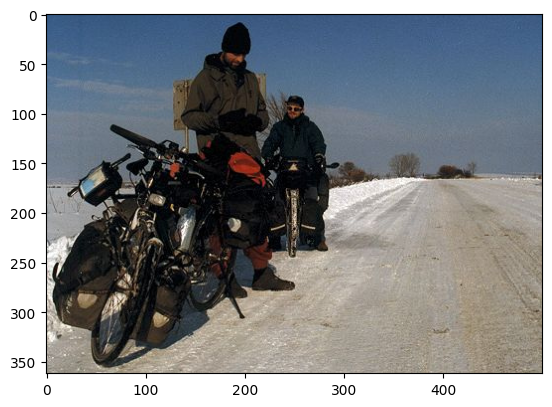

In [ ]:
generate_caption("95734035_84732a92c1.jpg")

---------------------Actual---------------------
startseq a calico cat raising its paws towards a dog with an open mouth endseq
startseq a cat swatting at a doberman dog endseq
startseq a dog and cat are fighting on a chair endseq
startseq a multicolor cat fighting with a black and brown dog in a red collar endseq
startseq the yellow and black cat and the brown and black dog are fighting endseq
--------------------Predicted--------------------
startseq a dog is standing on a bed with a dog in its mouth endseq


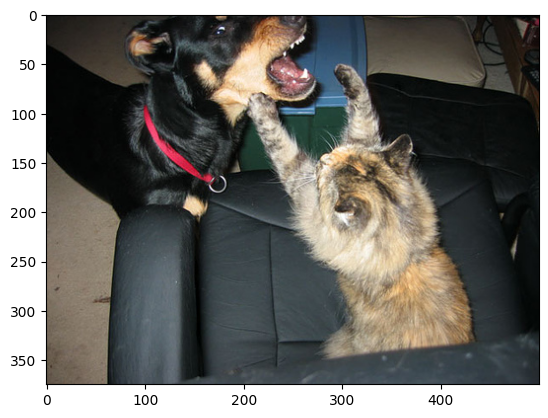

In [ ]:
generate_caption("97406261_5eea044056.jpg")